In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as Image
from skimage import feature
import os
import math
from sklearn.decomposition import PCA 
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import cross_val_score
import optuna
from sklearn.ensemble import RandomForestClassifier
import random
%matplotlib notebook 

def walk(path):
    table=[]
    if not os.path.exists(path):
        return -1
    for root,dirs,names in os.walk(path):
        for filename in names:
            table.append(os.path.join(root,filename))
    table.sort()
    return table

def Image_bound(img_table,label):
    img_bound=[]
    #garder que les parties du bounding box
    for i in range(len(img_table)):
        x1,y1,x2,y2=label[i]["box"]
        #print(x1,y1,x2,y2)
        img_bound.append(img_table[i][int(y1):int(y2),int(x1):int(x2)])
        #print(img_table[i].shape)
        """plt.imshow(img_bound[i],cmap='gray')
        plt.show()"""
    return img_bound
    
def calculer_hog(img_t,resize_x,resize_y,nb_bins,nbpixels_x,nbpixels_y,nbcelles_x,nbcelles_y):
    hog_vector=[]
    hog_image=[]
    for i in range(len(img_t)):
        img=cv2.resize(img_t[i],(resize_x,resize_y))
        fd, h =hog(img, orientations=nb_bins, pixels_per_cell=(nbpixels_x,nbpixels_y),
                           cells_per_block=(nbcelles_x, nbcelles_y), visualize=True)
        hog_vector.append(np.array(fd))
        hog_image.append(h)
    return hog_vector,hog_image

def calculer_orb(img_t,resize_x,resize_y,nf=500,eT=31,pS=31,fs=40):
    orb_vector=[]
    orb = cv2.ORB_create(nfeatures=nf,edgeThreshold=eT,patchSize=pS,fastThreshold=fs)  
    for i in range(len(img_t)):
        img=cv2.resize(img_table[i],(resize_x,resize_y))
        kp2, des = orb.detectAndCompute(img, None)
        des.resize((des.shape[0]*des.shape[1])) 
        orb_vector.append(des)
    return orb_vector
    
def vector_to_matrice(vector_table):
    mat=np.array([])
    for i in range(len(vector_table)):
        try:
            mat=np.vstack((mat,vector_table[i]))
        except:   
            mat=vector_table[i]
    return mat


def plot_scatter(data,k=4,plot=False):
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,200,0.0001)
    ret,labels,center=cv2.kmeans(np.float32(data),k,None,criteria,100,cv2.KMEANS_RANDOM_CENTERS)
    if(plot):
        colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
        for i in range(8):
            plt.scatter(data[labels.ravel()==i][:,0],data[labels.ravel()==i][:,1],c=colors[i])
            plt.scatter(center[:,0],center[:,1],s = 80,c = 'y', marker = 's')
        #plt.savefig('B_(32,32)_(8,8)_8_kmean')
        plt.show()
        for i in range(len(data)):
            plt.scatter(data[i][0],data[i][1],c=colors[label[i]["direction"]-1])
        #plt.scatter(center[:,0],center[:,1],s = 80,c = 'y', marker = 's')
        #plt.savefig('B_(32,32)_(8,8)_8_dataset')
        plt.show()
    return labels


def equilibrate_sample(nb_model,nb_image_par_direction):
    img_table=[]
    label={}
    model_table=[]
    label_table=[]
    for root,dirs,names in os.walk("data/image"):
        if(len(root.split('/'))==4):
            model_table.append(root)
    model_table.sort()
    for root,dirs,names in os.walk("data/label"):
        if(len(root.split('/'))==4):
            label_table.append(root)
    label_table.sort()
    N=nb_image_par_direction*5
    nb_sample=0
    index_model=0
    while(index_model<nb_model):
        m = random.sample(range(1, len(model_table)), 1)[0]
        imgpath = walk(model_table[m])
        if(len(imgpath)<N):
            continue
        print(m)
        model={}
        labelpath = walk(label_table[m])
        essay=0
        while(nb_sample<N*(index_model+1) and essay<N*20):
            i = random.sample(range(1, len(imgpath)), 1)[0]
            essay += 1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
            file_object = open(labelpath[i])
            lines = file_object.readlines()
            try:
                direction=int(lines[0][0])
            except:
                continue
            if(direction not in model.keys()):
                model[direction]=1
            else:
                if(model[direction] < nb_image_par_direction):
                        model[direction] += 1
                else:
                    continue
            label[nb_sample] = {}
            label[nb_sample]["direction"] = direction
            label[nb_sample]["box"] = lines[2].split()
            img_table.append(cv2.imread(imgpath[i],cv2.IMREAD_GRAYSCALE))    
            nb_sample += 1
        print(model)
        index_model+=1  
    return img_table,label

def read_image_label(image_dir_table,label_dir_table):
    img_table=[] 
    label={}
    a=0
    for i in range(len(image_dir_table)):
        path_image=image_dir_table[i]
        path_label=label_dir_table[i]
        imgpath=walk(path_image)
        labelpath=walk(path_label)
        for j in imgpath:
            img_table.append(cv2.imread(j,cv2.IMREAD_GRAYSCALE))
        for x in labelpath:
            label[a]={}
            file_object=open(x)
            lines = file_object.readlines()
            label[a]["direction"]=int(lines[0].split()[0])
            label[a]["box"]=lines[2].split()
            a+=1
    return img_table,label

def calculate_contingency_table(label_kmeans,label):
    contingency_table=np.zeros((5,len(np.unique(label_kmeans))))
    dic={}
    for i in range(len(label_kmeans)):
        dic[label[i]["direction"]]={}
    for i in range(len(label_kmeans)):
        try:
            dic[label[i]["direction"]]["%d"%label_kmeans[i][0]]+=1
        except:
            dic[label[i]["direction"]]["%d"%label_kmeans[i][0]]=1
    print(dic)
    for key in dic.keys():
        for k in dic[key].keys():
            contingency_table[key-1,int(k)-1]+=dic[key][k]
    return contingency_table

def adjusted_rand(contingency_table,N):
    row_sum=contingency_table.sum(axis=0)
    column_sum=contingency_table.sum(axis=1)
    sum_ij=(contingency_table*np.where(contingency_table==0,0,contingency_table-1)/2).sum()
    sum_ai=(row_sum*np.where(row_sum==0,0,row_sum-1)/2).sum()
    sum_bi=(row_sum*np.where(row_sum==0,0,row_sum-1)/2).sum()
    ARI=(sum_ij-(sum_ai*sum_bi)/((N*N-1)*2))/((0.5*(sum_ai+sum_bi))-(sum_ai*sum_bi)/((N*N-1)*2))
    return ARI

def cloest_centroid(vector,centroid_table):
    distance=((centroid_table-vector)**2).sum(axis=1)
    return np.argmin(distance)

import optuna
def objective(trial,index,patch):
    num_pca=trial.suggest_discrete_uniform("num_pca",0.5,0.99,0.01)
    num_estimators=trial.suggest_int("num_estimators",10,100)
    rf=RandomForestClassifier(n_estimators=num_estimators,random_state=0)
    Xtrain, Xtest, ytrain, ytest = train_test_split(patch[index], labels,random_state=0)
    bound=vector_to_matrice(Xtrain)
    test=vector_to_matrice(Xtest)
    p=PCA(n_components=num_pca)
    pca_bound=preprocessing.normalize(p.fit_transform(bound))
    rf.fit(pca_bound,ytrain)
    test=p.transform(test)
    res=rf.predict(test)
    accuracy=0
    for i in range(len(res)):
            if(res[i]==ytest[i]):
                accuracy+=1
    return accuracy/len(test)

In [4]:
path_dir="data/image"
label_dir="data/label"
img_table,label=equilibrate_sample(10,2)
img_bound=Image_bound(img_table,label)
labels=[]
for i in label.keys():
    labels.append(label[i]["direction"])

898
{4: 2, 5: 2, 1: 2, 3: 2, 2: 2}
283
{4: 2, 2: 2, 1: 2, 3: 2, 5: 2}
1176
{4: 2, 5: 2, 3: 2, 1: 2, 2: 2}
202
{1: 2, 4: 2, 5: 2, 3: 2, 2: 2}
1636
{5: 2, 2: 2, 4: 2, 1: 2, 3: 2}
1394
{4: 2, 5: 2, 2: 2, 1: 2, 3: 2}
907
{4: 2, 1: 2, 5: 2, 2: 2}
1224
{5: 2, 4: 2, 3: 2, 2: 2, 1: 2}
221
{4: 2, 1: 2, 3: 2, 5: 2, 2: 2}
653
{4: 2, 3: 2, 1: 2, 2: 2, 5: 2}


In [10]:
hp1=[]
for  i in range(20,130,10):
    hp1.append(calculer_hog(img_bound,512,512,5,i,i,1,1)[0])
    print("1 :",i)
hp2=[]
for  i in range(20,130,10):
    hp2.append(calculer_hog(img_bound,512,512,5,i,i,2,2)[0])
    print("2 :",i)
hp3=[]
for  i in range(20,130,10):
    hp3.append(calculer_hog(img_bound,512,512,5,i,i,3,3)[0])
    print("3 :",i)
hp4=[]
for  i in range(20,130,10):
    hp4.append(calculer_hog(img_bound,512,512,5,i,i,4,4)[0])
    print("4 :",i)


1 : 20
1 : 30
1 : 40
1 : 50
1 : 60
1 : 70
1 : 80
1 : 90
1 : 100
1 : 110
1 : 120
2 : 20
2 : 30
2 : 40
2 : 50
2 : 60
2 : 70
2 : 80
2 : 90
2 : 100
2 : 110
2 : 120
3 : 20
3 : 30
3 : 40
3 : 50
3 : 60
3 : 70
3 : 80
3 : 90
3 : 100
3 : 110
3 : 120
4 : 20
4 : 30
4 : 40
4 : 50
4 : 60
4 : 70
4 : 80
4 : 90
4 : 100
4 : 110
4 : 120


In [13]:
op_v1=[]
op_p1=[]
for i in range(len(hp1)):
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial:objective(trial,i,hp1), n_trials=100)
    op_v1.append(study.best_value)
    op_p1.append(study.best_params)
op_v2=[]
op_p2=[]
for i in range(len(hp2)):
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial:objective(trial,i,hp2), n_trials=100)
    op_v2.append(study.best_value)
    op_p2.append(study.best_params)
op_v3=[]
op_p3=[]
for i in range(len(hp3)):
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial:objective(trial,i,hp3), n_trials=100)
    op_v3.append(study.best_value)
    op_p3.append(study.best_params)
op_v4=[]
op_p4=[]
for i in range(len(hp4)):
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial:objective(trial,i,hp4), n_trials=100)
    op_v4.append(study.best_value)
    op_p4.append(study.best_params)

[I 2020-03-26 22:45:03,886] Finished trial#0 resulted in value: 0.68. Current best value is 0.68 with parameters: {'num_pca': 0.9199999999999999, 'num_estimators': 93}.
[I 2020-03-26 22:45:03,991] Finished trial#1 resulted in value: 0.6. Current best value is 0.68 with parameters: {'num_pca': 0.9199999999999999, 'num_estimators': 93}.
[I 2020-03-26 22:45:04,164] Finished trial#2 resulted in value: 0.64. Current best value is 0.68 with parameters: {'num_pca': 0.9199999999999999, 'num_estimators': 93}.
[I 2020-03-26 22:45:04,331] Finished trial#3 resulted in value: 0.72. Current best value is 0.72 with parameters: {'num_pca': 0.5, 'num_estimators': 42}.
[I 2020-03-26 22:45:04,554] Finished trial#4 resulted in value: 0.68. Current best value is 0.72 with parameters: {'num_pca': 0.5, 'num_estimators': 42}.
[I 2020-03-26 22:45:04,724] Finished trial#5 resulted in value: 0.68. Current best value is 0.72 with parameters: {'num_pca': 0.5, 'num_estimators': 42}.
[I 2020-03-26 22:45:04,834] Fini

[I 2020-03-26 22:45:11,909] Finished trial#52 resulted in value: 0.72. Current best value is 0.8 with parameters: {'num_pca': 0.8, 'num_estimators': 27}.
[I 2020-03-26 22:45:12,035] Finished trial#53 resulted in value: 0.6. Current best value is 0.8 with parameters: {'num_pca': 0.8, 'num_estimators': 27}.
[I 2020-03-26 22:45:12,181] Finished trial#54 resulted in value: 0.68. Current best value is 0.8 with parameters: {'num_pca': 0.8, 'num_estimators': 27}.
[I 2020-03-26 22:45:12,275] Finished trial#55 resulted in value: 0.48. Current best value is 0.8 with parameters: {'num_pca': 0.8, 'num_estimators': 27}.
[I 2020-03-26 22:45:12,390] Finished trial#56 resulted in value: 0.64. Current best value is 0.8 with parameters: {'num_pca': 0.8, 'num_estimators': 27}.
[I 2020-03-26 22:45:12,495] Finished trial#57 resulted in value: 0.72. Current best value is 0.8 with parameters: {'num_pca': 0.8, 'num_estimators': 27}.
[I 2020-03-26 22:45:12,593] Finished trial#58 resulted in value: 0.64. Curren

[I 2020-03-26 22:45:19,962] Finished trial#5 resulted in value: 0.72. Current best value is 0.76 with parameters: {'num_pca': 0.99, 'num_estimators': 50}.
[I 2020-03-26 22:45:20,175] Finished trial#6 resulted in value: 0.72. Current best value is 0.76 with parameters: {'num_pca': 0.99, 'num_estimators': 50}.
[I 2020-03-26 22:45:20,295] Finished trial#7 resulted in value: 0.72. Current best value is 0.76 with parameters: {'num_pca': 0.99, 'num_estimators': 50}.
[I 2020-03-26 22:45:20,436] Finished trial#8 resulted in value: 0.6. Current best value is 0.76 with parameters: {'num_pca': 0.99, 'num_estimators': 50}.
[I 2020-03-26 22:45:20,590] Finished trial#9 resulted in value: 0.56. Current best value is 0.76 with parameters: {'num_pca': 0.99, 'num_estimators': 50}.
[I 2020-03-26 22:45:20,726] Finished trial#10 resulted in value: 0.68. Current best value is 0.76 with parameters: {'num_pca': 0.99, 'num_estimators': 50}.
[I 2020-03-26 22:45:20,858] Finished trial#11 resulted in value: 0.72.

[I 2020-03-26 22:45:27,771] Finished trial#57 resulted in value: 0.72. Current best value is 0.8 with parameters: {'num_pca': 0.94, 'num_estimators': 50}.
[I 2020-03-26 22:45:27,915] Finished trial#58 resulted in value: 0.52. Current best value is 0.8 with parameters: {'num_pca': 0.94, 'num_estimators': 50}.
[I 2020-03-26 22:45:28,082] Finished trial#59 resulted in value: 0.72. Current best value is 0.8 with parameters: {'num_pca': 0.94, 'num_estimators': 50}.
[I 2020-03-26 22:45:28,222] Finished trial#60 resulted in value: 0.8. Current best value is 0.8 with parameters: {'num_pca': 0.94, 'num_estimators': 50}.
[I 2020-03-26 22:45:28,362] Finished trial#61 resulted in value: 0.8. Current best value is 0.8 with parameters: {'num_pca': 0.94, 'num_estimators': 50}.
[I 2020-03-26 22:45:28,501] Finished trial#62 resulted in value: 0.76. Current best value is 0.8 with parameters: {'num_pca': 0.94, 'num_estimators': 50}.
[I 2020-03-26 22:45:28,628] Finished trial#63 resulted in value: 0.64. C

[I 2020-03-26 22:45:35,455] Finished trial#9 resulted in value: 0.72. Current best value is 0.76 with parameters: {'num_pca': 0.79, 'num_estimators': 87}.
[I 2020-03-26 22:45:35,631] Finished trial#10 resulted in value: 0.64. Current best value is 0.76 with parameters: {'num_pca': 0.79, 'num_estimators': 87}.
[I 2020-03-26 22:45:35,733] Finished trial#11 resulted in value: 0.68. Current best value is 0.76 with parameters: {'num_pca': 0.79, 'num_estimators': 87}.
[I 2020-03-26 22:45:35,849] Finished trial#12 resulted in value: 0.68. Current best value is 0.76 with parameters: {'num_pca': 0.79, 'num_estimators': 87}.
[I 2020-03-26 22:45:35,934] Finished trial#13 resulted in value: 0.56. Current best value is 0.76 with parameters: {'num_pca': 0.79, 'num_estimators': 87}.
[I 2020-03-26 22:45:36,052] Finished trial#14 resulted in value: 0.76. Current best value is 0.76 with parameters: {'num_pca': 0.79, 'num_estimators': 87}.
[I 2020-03-26 22:45:36,222] Finished trial#15 resulted in value: 

[I 2020-03-26 22:45:42,164] Finished trial#61 resulted in value: 0.68. Current best value is 0.8 with parameters: {'num_pca': 0.75, 'num_estimators': 31}.
[I 2020-03-26 22:45:42,304] Finished trial#62 resulted in value: 0.6. Current best value is 0.8 with parameters: {'num_pca': 0.75, 'num_estimators': 31}.
[I 2020-03-26 22:45:42,417] Finished trial#63 resulted in value: 0.8. Current best value is 0.8 with parameters: {'num_pca': 0.75, 'num_estimators': 31}.
[I 2020-03-26 22:45:42,529] Finished trial#64 resulted in value: 0.8. Current best value is 0.8 with parameters: {'num_pca': 0.75, 'num_estimators': 31}.
[I 2020-03-26 22:45:42,647] Finished trial#65 resulted in value: 0.6. Current best value is 0.8 with parameters: {'num_pca': 0.75, 'num_estimators': 31}.
[I 2020-03-26 22:45:42,768] Finished trial#66 resulted in value: 0.64. Current best value is 0.8 with parameters: {'num_pca': 0.75, 'num_estimators': 31}.
[I 2020-03-26 22:45:42,932] Finished trial#67 resulted in value: 0.76. Cur

[I 2020-03-26 22:45:48,768] Finished trial#12 resulted in value: 0.56. Current best value is 0.68 with parameters: {'num_pca': 0.5700000000000001, 'num_estimators': 49}.
[I 2020-03-26 22:45:48,879] Finished trial#13 resulted in value: 0.72. Current best value is 0.72 with parameters: {'num_pca': 0.5700000000000001, 'num_estimators': 41}.
[I 2020-03-26 22:45:49,013] Finished trial#14 resulted in value: 0.6. Current best value is 0.72 with parameters: {'num_pca': 0.5700000000000001, 'num_estimators': 41}.
[I 2020-03-26 22:45:49,168] Finished trial#15 resulted in value: 0.68. Current best value is 0.72 with parameters: {'num_pca': 0.5700000000000001, 'num_estimators': 41}.
[I 2020-03-26 22:45:49,286] Finished trial#16 resulted in value: 0.72. Current best value is 0.72 with parameters: {'num_pca': 0.5700000000000001, 'num_estimators': 41}.
[I 2020-03-26 22:45:49,398] Finished trial#17 resulted in value: 0.56. Current best value is 0.72 with parameters: {'num_pca': 0.5700000000000001, 'num

[I 2020-03-26 22:45:55,251] Finished trial#60 resulted in value: 0.64. Current best value is 0.76 with parameters: {'num_pca': 0.5700000000000001, 'num_estimators': 27}.
[I 2020-03-26 22:45:55,384] Finished trial#61 resulted in value: 0.76. Current best value is 0.76 with parameters: {'num_pca': 0.5700000000000001, 'num_estimators': 27}.
[I 2020-03-26 22:45:55,488] Finished trial#62 resulted in value: 0.48. Current best value is 0.76 with parameters: {'num_pca': 0.5700000000000001, 'num_estimators': 27}.
[I 2020-03-26 22:45:55,586] Finished trial#63 resulted in value: 0.6. Current best value is 0.76 with parameters: {'num_pca': 0.5700000000000001, 'num_estimators': 27}.
[I 2020-03-26 22:45:55,733] Finished trial#64 resulted in value: 0.68. Current best value is 0.76 with parameters: {'num_pca': 0.5700000000000001, 'num_estimators': 27}.
[I 2020-03-26 22:45:55,833] Finished trial#65 resulted in value: 0.76. Current best value is 0.76 with parameters: {'num_pca': 0.5700000000000001, 'num

[I 2020-03-26 22:46:01,005] Finished trial#9 resulted in value: 0.68. Current best value is 0.68 with parameters: {'num_pca': 0.51, 'num_estimators': 33}.
[I 2020-03-26 22:46:01,130] Finished trial#10 resulted in value: 0.52. Current best value is 0.68 with parameters: {'num_pca': 0.51, 'num_estimators': 33}.
[I 2020-03-26 22:46:01,271] Finished trial#11 resulted in value: 0.68. Current best value is 0.68 with parameters: {'num_pca': 0.51, 'num_estimators': 33}.
[I 2020-03-26 22:46:01,424] Finished trial#12 resulted in value: 0.6. Current best value is 0.68 with parameters: {'num_pca': 0.51, 'num_estimators': 33}.
[I 2020-03-26 22:46:01,567] Finished trial#13 resulted in value: 0.72. Current best value is 0.72 with parameters: {'num_pca': 0.62, 'num_estimators': 37}.
[I 2020-03-26 22:46:01,671] Finished trial#14 resulted in value: 0.6. Current best value is 0.72 with parameters: {'num_pca': 0.62, 'num_estimators': 37}.
[I 2020-03-26 22:46:01,800] Finished trial#15 resulted in value: 0.

[I 2020-03-26 22:46:08,680] Finished trial#61 resulted in value: 0.6. Current best value is 0.76 with parameters: {'num_pca': 0.67, 'num_estimators': 95}.
[I 2020-03-26 22:46:08,858] Finished trial#62 resulted in value: 0.72. Current best value is 0.76 with parameters: {'num_pca': 0.67, 'num_estimators': 95}.
[I 2020-03-26 22:46:09,036] Finished trial#63 resulted in value: 0.72. Current best value is 0.76 with parameters: {'num_pca': 0.67, 'num_estimators': 95}.
[I 2020-03-26 22:46:09,219] Finished trial#64 resulted in value: 0.72. Current best value is 0.76 with parameters: {'num_pca': 0.67, 'num_estimators': 95}.
[I 2020-03-26 22:46:09,420] Finished trial#65 resulted in value: 0.6. Current best value is 0.76 with parameters: {'num_pca': 0.67, 'num_estimators': 95}.
[I 2020-03-26 22:46:09,592] Finished trial#66 resulted in value: 0.68. Current best value is 0.76 with parameters: {'num_pca': 0.67, 'num_estimators': 95}.
[I 2020-03-26 22:46:09,771] Finished trial#67 resulted in value: 0

[I 2020-03-26 22:46:17,474] Finished trial#13 resulted in value: 0.52. Current best value is 0.6 with parameters: {'num_pca': 0.56, 'num_estimators': 38}.
[I 2020-03-26 22:46:17,627] Finished trial#14 resulted in value: 0.52. Current best value is 0.6 with parameters: {'num_pca': 0.56, 'num_estimators': 38}.
[I 2020-03-26 22:46:17,828] Finished trial#15 resulted in value: 0.52. Current best value is 0.6 with parameters: {'num_pca': 0.56, 'num_estimators': 38}.
[I 2020-03-26 22:46:17,975] Finished trial#16 resulted in value: 0.56. Current best value is 0.6 with parameters: {'num_pca': 0.56, 'num_estimators': 38}.
[I 2020-03-26 22:46:18,072] Finished trial#17 resulted in value: 0.36. Current best value is 0.6 with parameters: {'num_pca': 0.56, 'num_estimators': 38}.
[I 2020-03-26 22:46:18,261] Finished trial#18 resulted in value: 0.52. Current best value is 0.6 with parameters: {'num_pca': 0.56, 'num_estimators': 38}.
[I 2020-03-26 22:46:18,425] Finished trial#19 resulted in value: 0.56.

[I 2020-03-26 22:46:24,262] Finished trial#65 resulted in value: 0.52. Current best value is 0.6 with parameters: {'num_pca': 0.56, 'num_estimators': 38}.
[I 2020-03-26 22:46:24,379] Finished trial#66 resulted in value: 0.6. Current best value is 0.6 with parameters: {'num_pca': 0.56, 'num_estimators': 38}.
[I 2020-03-26 22:46:24,521] Finished trial#67 resulted in value: 0.52. Current best value is 0.6 with parameters: {'num_pca': 0.56, 'num_estimators': 38}.
[I 2020-03-26 22:46:24,649] Finished trial#68 resulted in value: 0.6. Current best value is 0.6 with parameters: {'num_pca': 0.56, 'num_estimators': 38}.
[I 2020-03-26 22:46:24,795] Finished trial#69 resulted in value: 0.52. Current best value is 0.6 with parameters: {'num_pca': 0.56, 'num_estimators': 38}.
[I 2020-03-26 22:46:24,926] Finished trial#70 resulted in value: 0.56. Current best value is 0.6 with parameters: {'num_pca': 0.56, 'num_estimators': 38}.
[I 2020-03-26 22:46:25,042] Finished trial#71 resulted in value: 0.56. C

[I 2020-03-26 22:46:31,342] Finished trial#18 resulted in value: 0.6. Current best value is 0.68 with parameters: {'num_pca': 0.66, 'num_estimators': 73}.
[I 2020-03-26 22:46:31,499] Finished trial#19 resulted in value: 0.6. Current best value is 0.68 with parameters: {'num_pca': 0.66, 'num_estimators': 73}.
[I 2020-03-26 22:46:31,665] Finished trial#20 resulted in value: 0.52. Current best value is 0.68 with parameters: {'num_pca': 0.66, 'num_estimators': 73}.
[I 2020-03-26 22:46:31,824] Finished trial#21 resulted in value: 0.6. Current best value is 0.68 with parameters: {'num_pca': 0.66, 'num_estimators': 73}.
[I 2020-03-26 22:46:32,024] Finished trial#22 resulted in value: 0.56. Current best value is 0.68 with parameters: {'num_pca': 0.66, 'num_estimators': 73}.
[I 2020-03-26 22:46:32,194] Finished trial#23 resulted in value: 0.56. Current best value is 0.68 with parameters: {'num_pca': 0.66, 'num_estimators': 73}.
[I 2020-03-26 22:46:32,419] Finished trial#24 resulted in value: 0.

[I 2020-03-26 22:46:38,835] Finished trial#70 resulted in value: 0.52. Current best value is 0.72 with parameters: {'num_pca': 0.66, 'num_estimators': 95}.
[I 2020-03-26 22:46:38,967] Finished trial#71 resulted in value: 0.64. Current best value is 0.72 with parameters: {'num_pca': 0.66, 'num_estimators': 95}.
[I 2020-03-26 22:46:39,097] Finished trial#72 resulted in value: 0.64. Current best value is 0.72 with parameters: {'num_pca': 0.66, 'num_estimators': 95}.
[I 2020-03-26 22:46:39,216] Finished trial#73 resulted in value: 0.52. Current best value is 0.72 with parameters: {'num_pca': 0.66, 'num_estimators': 95}.
[I 2020-03-26 22:46:39,357] Finished trial#74 resulted in value: 0.64. Current best value is 0.72 with parameters: {'num_pca': 0.66, 'num_estimators': 95}.
[I 2020-03-26 22:46:39,470] Finished trial#75 resulted in value: 0.6. Current best value is 0.72 with parameters: {'num_pca': 0.66, 'num_estimators': 95}.
[I 2020-03-26 22:46:39,613] Finished trial#76 resulted in value: 

[I 2020-03-26 22:46:45,918] Finished trial#22 resulted in value: 0.44. Current best value is 0.6 with parameters: {'num_pca': 0.94, 'num_estimators': 73}.
[I 2020-03-26 22:46:46,016] Finished trial#23 resulted in value: 0.52. Current best value is 0.6 with parameters: {'num_pca': 0.94, 'num_estimators': 73}.
[I 2020-03-26 22:46:46,181] Finished trial#24 resulted in value: 0.52. Current best value is 0.6 with parameters: {'num_pca': 0.94, 'num_estimators': 73}.
[I 2020-03-26 22:46:46,370] Finished trial#25 resulted in value: 0.6. Current best value is 0.6 with parameters: {'num_pca': 0.94, 'num_estimators': 73}.
[I 2020-03-26 22:46:46,543] Finished trial#26 resulted in value: 0.52. Current best value is 0.6 with parameters: {'num_pca': 0.94, 'num_estimators': 73}.
[I 2020-03-26 22:46:46,689] Finished trial#27 resulted in value: 0.48. Current best value is 0.6 with parameters: {'num_pca': 0.94, 'num_estimators': 73}.
[I 2020-03-26 22:46:46,857] Finished trial#28 resulted in value: 0.44. 

[I 2020-03-26 22:46:54,018] Finished trial#74 resulted in value: 0.52. Current best value is 0.64 with parameters: {'num_pca': 0.94, 'num_estimators': 74}.
[I 2020-03-26 22:46:54,201] Finished trial#75 resulted in value: 0.6. Current best value is 0.64 with parameters: {'num_pca': 0.94, 'num_estimators': 74}.
[I 2020-03-26 22:46:54,338] Finished trial#76 resulted in value: 0.6. Current best value is 0.64 with parameters: {'num_pca': 0.94, 'num_estimators': 74}.
[I 2020-03-26 22:46:54,478] Finished trial#77 resulted in value: 0.44. Current best value is 0.64 with parameters: {'num_pca': 0.94, 'num_estimators': 74}.
[I 2020-03-26 22:46:54,624] Finished trial#78 resulted in value: 0.52. Current best value is 0.64 with parameters: {'num_pca': 0.94, 'num_estimators': 74}.
[I 2020-03-26 22:46:54,776] Finished trial#79 resulted in value: 0.56. Current best value is 0.64 with parameters: {'num_pca': 0.94, 'num_estimators': 74}.
[I 2020-03-26 22:46:54,967] Finished trial#80 resulted in value: 0

[I 2020-03-26 22:47:01,410] Finished trial#26 resulted in value: 0.44. Current best value is 0.6 with parameters: {'num_pca': 0.97, 'num_estimators': 50}.
[I 2020-03-26 22:47:01,527] Finished trial#27 resulted in value: 0.4. Current best value is 0.6 with parameters: {'num_pca': 0.97, 'num_estimators': 50}.
[I 2020-03-26 22:47:01,661] Finished trial#28 resulted in value: 0.36. Current best value is 0.6 with parameters: {'num_pca': 0.97, 'num_estimators': 50}.
[I 2020-03-26 22:47:01,803] Finished trial#29 resulted in value: 0.48. Current best value is 0.6 with parameters: {'num_pca': 0.97, 'num_estimators': 50}.
[I 2020-03-26 22:47:01,925] Finished trial#30 resulted in value: 0.4. Current best value is 0.6 with parameters: {'num_pca': 0.97, 'num_estimators': 50}.
[I 2020-03-26 22:47:02,071] Finished trial#31 resulted in value: 0.48. Current best value is 0.6 with parameters: {'num_pca': 0.97, 'num_estimators': 50}.
[I 2020-03-26 22:47:02,221] Finished trial#32 resulted in value: 0.32. C

[I 2020-03-26 22:47:09,317] Finished trial#78 resulted in value: 0.4. Current best value is 0.64 with parameters: {'num_pca': 0.97, 'num_estimators': 62}.
[I 2020-03-26 22:47:09,474] Finished trial#79 resulted in value: 0.4. Current best value is 0.64 with parameters: {'num_pca': 0.97, 'num_estimators': 62}.
[I 2020-03-26 22:47:09,615] Finished trial#80 resulted in value: 0.4. Current best value is 0.64 with parameters: {'num_pca': 0.97, 'num_estimators': 62}.
[I 2020-03-26 22:47:09,750] Finished trial#81 resulted in value: 0.52. Current best value is 0.64 with parameters: {'num_pca': 0.97, 'num_estimators': 62}.
[I 2020-03-26 22:47:09,915] Finished trial#82 resulted in value: 0.56. Current best value is 0.64 with parameters: {'num_pca': 0.97, 'num_estimators': 62}.
[I 2020-03-26 22:47:10,126] Finished trial#83 resulted in value: 0.52. Current best value is 0.64 with parameters: {'num_pca': 0.97, 'num_estimators': 62}.
[I 2020-03-26 22:47:10,314] Finished trial#84 resulted in value: 0.

[I 2020-03-26 22:47:16,992] Finished trial#28 resulted in value: 0.64. Current best value is 0.64 with parameters: {'num_pca': 0.8200000000000001, 'num_estimators': 89}.
[I 2020-03-26 22:47:17,152] Finished trial#29 resulted in value: 0.6. Current best value is 0.64 with parameters: {'num_pca': 0.8200000000000001, 'num_estimators': 89}.
[I 2020-03-26 22:47:17,298] Finished trial#30 resulted in value: 0.64. Current best value is 0.64 with parameters: {'num_pca': 0.8200000000000001, 'num_estimators': 89}.
[I 2020-03-26 22:47:17,473] Finished trial#31 resulted in value: 0.56. Current best value is 0.64 with parameters: {'num_pca': 0.8200000000000001, 'num_estimators': 89}.
[I 2020-03-26 22:47:17,620] Finished trial#32 resulted in value: 0.6. Current best value is 0.64 with parameters: {'num_pca': 0.8200000000000001, 'num_estimators': 89}.
[I 2020-03-26 22:47:17,765] Finished trial#33 resulted in value: 0.56. Current best value is 0.64 with parameters: {'num_pca': 0.8200000000000001, 'num_

[I 2020-03-26 22:47:23,722] Finished trial#76 resulted in value: 0.6. Current best value is 0.68 with parameters: {'num_pca': 0.9199999999999999, 'num_estimators': 38}.
[I 2020-03-26 22:47:23,840] Finished trial#77 resulted in value: 0.52. Current best value is 0.68 with parameters: {'num_pca': 0.9199999999999999, 'num_estimators': 38}.
[I 2020-03-26 22:47:23,963] Finished trial#78 resulted in value: 0.56. Current best value is 0.68 with parameters: {'num_pca': 0.9199999999999999, 'num_estimators': 38}.
[I 2020-03-26 22:47:24,115] Finished trial#79 resulted in value: 0.52. Current best value is 0.68 with parameters: {'num_pca': 0.9199999999999999, 'num_estimators': 38}.
[I 2020-03-26 22:47:24,261] Finished trial#80 resulted in value: 0.52. Current best value is 0.68 with parameters: {'num_pca': 0.9199999999999999, 'num_estimators': 38}.
[I 2020-03-26 22:47:24,427] Finished trial#81 resulted in value: 0.64. Current best value is 0.68 with parameters: {'num_pca': 0.9199999999999999, 'num

[I 2020-03-26 22:47:30,604] Finished trial#25 resulted in value: 0.32. Current best value is 0.6 with parameters: {'num_pca': 0.8500000000000001, 'num_estimators': 97}.
[I 2020-03-26 22:47:30,724] Finished trial#26 resulted in value: 0.56. Current best value is 0.6 with parameters: {'num_pca': 0.8500000000000001, 'num_estimators': 97}.
[I 2020-03-26 22:47:30,825] Finished trial#27 resulted in value: 0.36. Current best value is 0.6 with parameters: {'num_pca': 0.8500000000000001, 'num_estimators': 97}.
[I 2020-03-26 22:47:30,928] Finished trial#28 resulted in value: 0.4. Current best value is 0.6 with parameters: {'num_pca': 0.8500000000000001, 'num_estimators': 97}.
[I 2020-03-26 22:47:31,037] Finished trial#29 resulted in value: 0.44. Current best value is 0.6 with parameters: {'num_pca': 0.8500000000000001, 'num_estimators': 97}.
[I 2020-03-26 22:47:31,174] Finished trial#30 resulted in value: 0.24. Current best value is 0.6 with parameters: {'num_pca': 0.8500000000000001, 'num_estim

[I 2020-03-26 22:47:37,346] Finished trial#73 resulted in value: 0.56. Current best value is 0.6 with parameters: {'num_pca': 0.8500000000000001, 'num_estimators': 97}.
[I 2020-03-26 22:47:37,498] Finished trial#74 resulted in value: 0.56. Current best value is 0.6 with parameters: {'num_pca': 0.8500000000000001, 'num_estimators': 97}.
[I 2020-03-26 22:47:37,656] Finished trial#75 resulted in value: 0.6. Current best value is 0.6 with parameters: {'num_pca': 0.8500000000000001, 'num_estimators': 97}.
[I 2020-03-26 22:47:37,823] Finished trial#76 resulted in value: 0.4. Current best value is 0.6 with parameters: {'num_pca': 0.8500000000000001, 'num_estimators': 97}.
[I 2020-03-26 22:47:37,984] Finished trial#77 resulted in value: 0.44. Current best value is 0.6 with parameters: {'num_pca': 0.8500000000000001, 'num_estimators': 97}.
[I 2020-03-26 22:47:38,135] Finished trial#78 resulted in value: 0.44. Current best value is 0.6 with parameters: {'num_pca': 0.8500000000000001, 'num_estima

[I 2020-03-26 22:47:46,019] Finished trial#23 resulted in value: 0.56. Current best value is 0.68 with parameters: {'num_pca': 0.52, 'num_estimators': 36}.
[I 2020-03-26 22:47:46,231] Finished trial#24 resulted in value: 0.56. Current best value is 0.68 with parameters: {'num_pca': 0.52, 'num_estimators': 36}.
[I 2020-03-26 22:47:46,411] Finished trial#25 resulted in value: 0.56. Current best value is 0.68 with parameters: {'num_pca': 0.52, 'num_estimators': 36}.
[I 2020-03-26 22:47:46,637] Finished trial#26 resulted in value: 0.6. Current best value is 0.68 with parameters: {'num_pca': 0.52, 'num_estimators': 36}.
[I 2020-03-26 22:47:46,811] Finished trial#27 resulted in value: 0.52. Current best value is 0.68 with parameters: {'num_pca': 0.52, 'num_estimators': 36}.
[I 2020-03-26 22:47:47,026] Finished trial#28 resulted in value: 0.52. Current best value is 0.68 with parameters: {'num_pca': 0.52, 'num_estimators': 36}.
[I 2020-03-26 22:47:47,235] Finished trial#29 resulted in value: 

[I 2020-03-26 22:47:56,802] Finished trial#75 resulted in value: 0.52. Current best value is 0.72 with parameters: {'num_pca': 0.52, 'num_estimators': 53}.
[I 2020-03-26 22:47:57,009] Finished trial#76 resulted in value: 0.68. Current best value is 0.72 with parameters: {'num_pca': 0.52, 'num_estimators': 53}.
[I 2020-03-26 22:47:57,212] Finished trial#77 resulted in value: 0.64. Current best value is 0.72 with parameters: {'num_pca': 0.52, 'num_estimators': 53}.
[I 2020-03-26 22:47:57,422] Finished trial#78 resulted in value: 0.68. Current best value is 0.72 with parameters: {'num_pca': 0.52, 'num_estimators': 53}.
[I 2020-03-26 22:47:57,644] Finished trial#79 resulted in value: 0.52. Current best value is 0.72 with parameters: {'num_pca': 0.52, 'num_estimators': 53}.
[I 2020-03-26 22:47:57,841] Finished trial#80 resulted in value: 0.72. Current best value is 0.72 with parameters: {'num_pca': 0.52, 'num_estimators': 53}.
[I 2020-03-26 22:47:58,043] Finished trial#81 resulted in value:

[I 2020-03-26 22:48:06,573] Finished trial#27 resulted in value: 0.64. Current best value is 0.76 with parameters: {'num_pca': 0.91, 'num_estimators': 46}.
[I 2020-03-26 22:48:06,761] Finished trial#28 resulted in value: 0.52. Current best value is 0.76 with parameters: {'num_pca': 0.91, 'num_estimators': 46}.
[I 2020-03-26 22:48:06,879] Finished trial#29 resulted in value: 0.56. Current best value is 0.76 with parameters: {'num_pca': 0.91, 'num_estimators': 46}.
[I 2020-03-26 22:48:07,100] Finished trial#30 resulted in value: 0.64. Current best value is 0.76 with parameters: {'num_pca': 0.91, 'num_estimators': 46}.
[I 2020-03-26 22:48:07,257] Finished trial#31 resulted in value: 0.72. Current best value is 0.76 with parameters: {'num_pca': 0.91, 'num_estimators': 46}.
[I 2020-03-26 22:48:07,420] Finished trial#32 resulted in value: 0.56. Current best value is 0.76 with parameters: {'num_pca': 0.91, 'num_estimators': 46}.
[I 2020-03-26 22:48:07,607] Finished trial#33 resulted in value:

[I 2020-03-26 22:48:16,280] Finished trial#79 resulted in value: 0.64. Current best value is 0.76 with parameters: {'num_pca': 0.91, 'num_estimators': 46}.
[I 2020-03-26 22:48:16,478] Finished trial#80 resulted in value: 0.76. Current best value is 0.76 with parameters: {'num_pca': 0.91, 'num_estimators': 46}.
[I 2020-03-26 22:48:16,635] Finished trial#81 resulted in value: 0.6. Current best value is 0.76 with parameters: {'num_pca': 0.91, 'num_estimators': 46}.
[I 2020-03-26 22:48:16,829] Finished trial#82 resulted in value: 0.76. Current best value is 0.76 with parameters: {'num_pca': 0.91, 'num_estimators': 46}.
[I 2020-03-26 22:48:17,020] Finished trial#83 resulted in value: 0.72. Current best value is 0.76 with parameters: {'num_pca': 0.91, 'num_estimators': 46}.
[I 2020-03-26 22:48:17,217] Finished trial#84 resulted in value: 0.6. Current best value is 0.76 with parameters: {'num_pca': 0.91, 'num_estimators': 46}.
[I 2020-03-26 22:48:17,396] Finished trial#85 resulted in value: 0

[I 2020-03-26 22:48:25,088] Finished trial#31 resulted in value: 0.68. Current best value is 0.76 with parameters: {'num_pca': 0.81, 'num_estimators': 92}.
[I 2020-03-26 22:48:25,211] Finished trial#32 resulted in value: 0.72. Current best value is 0.76 with parameters: {'num_pca': 0.81, 'num_estimators': 92}.
[I 2020-03-26 22:48:25,384] Finished trial#33 resulted in value: 0.68. Current best value is 0.76 with parameters: {'num_pca': 0.81, 'num_estimators': 92}.
[I 2020-03-26 22:48:25,533] Finished trial#34 resulted in value: 0.76. Current best value is 0.76 with parameters: {'num_pca': 0.81, 'num_estimators': 92}.
[I 2020-03-26 22:48:25,682] Finished trial#35 resulted in value: 0.76. Current best value is 0.76 with parameters: {'num_pca': 0.81, 'num_estimators': 92}.
[I 2020-03-26 22:48:25,838] Finished trial#36 resulted in value: 0.68. Current best value is 0.76 with parameters: {'num_pca': 0.81, 'num_estimators': 92}.
[I 2020-03-26 22:48:25,990] Finished trial#37 resulted in value:

[I 2020-03-26 22:48:33,348] Finished trial#83 resulted in value: 0.68. Current best value is 0.8 with parameters: {'num_pca': 0.97, 'num_estimators': 64}.
[I 2020-03-26 22:48:33,458] Finished trial#84 resulted in value: 0.56. Current best value is 0.8 with parameters: {'num_pca': 0.97, 'num_estimators': 64}.
[I 2020-03-26 22:48:33,604] Finished trial#85 resulted in value: 0.8. Current best value is 0.8 with parameters: {'num_pca': 0.97, 'num_estimators': 64}.
[I 2020-03-26 22:48:33,736] Finished trial#86 resulted in value: 0.64. Current best value is 0.8 with parameters: {'num_pca': 0.97, 'num_estimators': 64}.
[I 2020-03-26 22:48:33,881] Finished trial#87 resulted in value: 0.72. Current best value is 0.8 with parameters: {'num_pca': 0.97, 'num_estimators': 64}.
[I 2020-03-26 22:48:34,021] Finished trial#88 resulted in value: 0.76. Current best value is 0.8 with parameters: {'num_pca': 0.97, 'num_estimators': 64}.
[I 2020-03-26 22:48:34,175] Finished trial#89 resulted in value: 0.64. 

[I 2020-03-26 22:48:40,018] Finished trial#34 resulted in value: 0.76. Current best value is 0.76 with parameters: {'num_pca': 0.9199999999999999, 'num_estimators': 18}.
[I 2020-03-26 22:48:40,110] Finished trial#35 resulted in value: 0.48. Current best value is 0.76 with parameters: {'num_pca': 0.9199999999999999, 'num_estimators': 18}.
[I 2020-03-26 22:48:40,222] Finished trial#36 resulted in value: 0.6. Current best value is 0.76 with parameters: {'num_pca': 0.9199999999999999, 'num_estimators': 18}.
[I 2020-03-26 22:48:40,322] Finished trial#37 resulted in value: 0.52. Current best value is 0.76 with parameters: {'num_pca': 0.9199999999999999, 'num_estimators': 18}.
[I 2020-03-26 22:48:40,433] Finished trial#38 resulted in value: 0.6. Current best value is 0.76 with parameters: {'num_pca': 0.9199999999999999, 'num_estimators': 18}.
[I 2020-03-26 22:48:40,555] Finished trial#39 resulted in value: 0.6. Current best value is 0.76 with parameters: {'num_pca': 0.9199999999999999, 'num_e

[I 2020-03-26 22:48:45,456] Finished trial#82 resulted in value: 0.56. Current best value is 0.8 with parameters: {'num_pca': 0.9199999999999999, 'num_estimators': 22}.
[I 2020-03-26 22:48:45,603] Finished trial#83 resulted in value: 0.64. Current best value is 0.8 with parameters: {'num_pca': 0.9199999999999999, 'num_estimators': 22}.
[I 2020-03-26 22:48:45,702] Finished trial#84 resulted in value: 0.76. Current best value is 0.8 with parameters: {'num_pca': 0.9199999999999999, 'num_estimators': 22}.
[I 2020-03-26 22:48:45,805] Finished trial#85 resulted in value: 0.52. Current best value is 0.8 with parameters: {'num_pca': 0.9199999999999999, 'num_estimators': 22}.
[I 2020-03-26 22:48:45,906] Finished trial#86 resulted in value: 0.76. Current best value is 0.8 with parameters: {'num_pca': 0.9199999999999999, 'num_estimators': 22}.
[I 2020-03-26 22:48:46,006] Finished trial#87 resulted in value: 0.56. Current best value is 0.8 with parameters: {'num_pca': 0.9199999999999999, 'num_esti

[I 2020-03-26 22:48:52,242] Finished trial#33 resulted in value: 0.76. Current best value is 0.76 with parameters: {'num_pca': 0.7, 'num_estimators': 90}.
[I 2020-03-26 22:48:52,421] Finished trial#34 resulted in value: 0.72. Current best value is 0.76 with parameters: {'num_pca': 0.7, 'num_estimators': 90}.
[I 2020-03-26 22:48:52,588] Finished trial#35 resulted in value: 0.72. Current best value is 0.76 with parameters: {'num_pca': 0.7, 'num_estimators': 90}.
[I 2020-03-26 22:48:52,744] Finished trial#36 resulted in value: 0.6. Current best value is 0.76 with parameters: {'num_pca': 0.7, 'num_estimators': 90}.
[I 2020-03-26 22:48:52,903] Finished trial#37 resulted in value: 0.76. Current best value is 0.76 with parameters: {'num_pca': 0.7, 'num_estimators': 90}.
[I 2020-03-26 22:48:53,071] Finished trial#38 resulted in value: 0.72. Current best value is 0.76 with parameters: {'num_pca': 0.7, 'num_estimators': 90}.
[I 2020-03-26 22:48:53,248] Finished trial#39 resulted in value: 0.72. 

[I 2020-03-26 22:49:00,717] Finished trial#85 resulted in value: 0.72. Current best value is 0.76 with parameters: {'num_pca': 0.7, 'num_estimators': 90}.
[I 2020-03-26 22:49:00,872] Finished trial#86 resulted in value: 0.72. Current best value is 0.76 with parameters: {'num_pca': 0.7, 'num_estimators': 90}.
[I 2020-03-26 22:49:01,047] Finished trial#87 resulted in value: 0.76. Current best value is 0.76 with parameters: {'num_pca': 0.7, 'num_estimators': 90}.
[I 2020-03-26 22:49:01,233] Finished trial#88 resulted in value: 0.68. Current best value is 0.76 with parameters: {'num_pca': 0.7, 'num_estimators': 90}.
[I 2020-03-26 22:49:01,396] Finished trial#89 resulted in value: 0.68. Current best value is 0.76 with parameters: {'num_pca': 0.7, 'num_estimators': 90}.
[I 2020-03-26 22:49:01,587] Finished trial#90 resulted in value: 0.68. Current best value is 0.76 with parameters: {'num_pca': 0.7, 'num_estimators': 90}.
[I 2020-03-26 22:49:01,760] Finished trial#91 resulted in value: 0.76.

[I 2020-03-26 22:49:07,943] Finished trial#34 resulted in value: 0.64. Current best value is 0.72 with parameters: {'num_pca': 0.8200000000000001, 'num_estimators': 24}.
[I 2020-03-26 22:49:08,083] Finished trial#35 resulted in value: 0.6. Current best value is 0.72 with parameters: {'num_pca': 0.8200000000000001, 'num_estimators': 24}.
[I 2020-03-26 22:49:08,205] Finished trial#36 resulted in value: 0.68. Current best value is 0.72 with parameters: {'num_pca': 0.8200000000000001, 'num_estimators': 24}.
[I 2020-03-26 22:49:08,408] Finished trial#37 resulted in value: 0.72. Current best value is 0.72 with parameters: {'num_pca': 0.8200000000000001, 'num_estimators': 24}.
[I 2020-03-26 22:49:08,609] Finished trial#38 resulted in value: 0.6. Current best value is 0.72 with parameters: {'num_pca': 0.8200000000000001, 'num_estimators': 24}.
[I 2020-03-26 22:49:08,755] Finished trial#39 resulted in value: 0.64. Current best value is 0.72 with parameters: {'num_pca': 0.8200000000000001, 'num_

[I 2020-03-26 22:49:16,169] Finished trial#83 resulted in value: 0.56. Current best value is 0.76 with parameters: {'num_pca': 0.65, 'num_estimators': 75}.
[I 2020-03-26 22:49:16,353] Finished trial#84 resulted in value: 0.76. Current best value is 0.76 with parameters: {'num_pca': 0.65, 'num_estimators': 75}.
[I 2020-03-26 22:49:16,569] Finished trial#85 resulted in value: 0.64. Current best value is 0.76 with parameters: {'num_pca': 0.65, 'num_estimators': 75}.
[I 2020-03-26 22:49:16,773] Finished trial#86 resulted in value: 0.68. Current best value is 0.76 with parameters: {'num_pca': 0.65, 'num_estimators': 75}.
[I 2020-03-26 22:49:16,960] Finished trial#87 resulted in value: 0.52. Current best value is 0.76 with parameters: {'num_pca': 0.65, 'num_estimators': 75}.
[I 2020-03-26 22:49:17,197] Finished trial#88 resulted in value: 0.76. Current best value is 0.76 with parameters: {'num_pca': 0.65, 'num_estimators': 75}.
[I 2020-03-26 22:49:17,369] Finished trial#89 resulted in value:

[I 2020-03-26 22:49:24,511] Finished trial#35 resulted in value: 0.68. Current best value is 0.76 with parameters: {'num_pca': 0.63, 'num_estimators': 50}.
[I 2020-03-26 22:49:24,645] Finished trial#36 resulted in value: 0.6. Current best value is 0.76 with parameters: {'num_pca': 0.63, 'num_estimators': 50}.
[I 2020-03-26 22:49:24,789] Finished trial#37 resulted in value: 0.68. Current best value is 0.76 with parameters: {'num_pca': 0.63, 'num_estimators': 50}.
[I 2020-03-26 22:49:24,932] Finished trial#38 resulted in value: 0.6. Current best value is 0.76 with parameters: {'num_pca': 0.63, 'num_estimators': 50}.
[I 2020-03-26 22:49:25,108] Finished trial#39 resulted in value: 0.64. Current best value is 0.76 with parameters: {'num_pca': 0.63, 'num_estimators': 50}.
[I 2020-03-26 22:49:25,319] Finished trial#40 resulted in value: 0.76. Current best value is 0.76 with parameters: {'num_pca': 0.63, 'num_estimators': 50}.
[I 2020-03-26 22:49:25,475] Finished trial#41 resulted in value: 0

[I 2020-03-26 22:49:32,942] Finished trial#87 resulted in value: 0.76. Current best value is 0.76 with parameters: {'num_pca': 0.63, 'num_estimators': 50}.
[I 2020-03-26 22:49:33,076] Finished trial#88 resulted in value: 0.68. Current best value is 0.76 with parameters: {'num_pca': 0.63, 'num_estimators': 50}.
[I 2020-03-26 22:49:33,240] Finished trial#89 resulted in value: 0.68. Current best value is 0.76 with parameters: {'num_pca': 0.63, 'num_estimators': 50}.
[I 2020-03-26 22:49:33,401] Finished trial#90 resulted in value: 0.72. Current best value is 0.76 with parameters: {'num_pca': 0.63, 'num_estimators': 50}.
[I 2020-03-26 22:49:33,554] Finished trial#91 resulted in value: 0.72. Current best value is 0.76 with parameters: {'num_pca': 0.63, 'num_estimators': 50}.
[I 2020-03-26 22:49:33,721] Finished trial#92 resulted in value: 0.64. Current best value is 0.76 with parameters: {'num_pca': 0.63, 'num_estimators': 50}.
[I 2020-03-26 22:49:33,875] Finished trial#93 resulted in value:

[I 2020-03-26 22:49:41,040] Finished trial#39 resulted in value: 0.72. Current best value is 0.76 with parameters: {'num_pca': 0.87, 'num_estimators': 88}.
[I 2020-03-26 22:49:41,225] Finished trial#40 resulted in value: 0.64. Current best value is 0.76 with parameters: {'num_pca': 0.87, 'num_estimators': 88}.
[I 2020-03-26 22:49:41,400] Finished trial#41 resulted in value: 0.64. Current best value is 0.76 with parameters: {'num_pca': 0.87, 'num_estimators': 88}.
[I 2020-03-26 22:49:41,551] Finished trial#42 resulted in value: 0.68. Current best value is 0.76 with parameters: {'num_pca': 0.87, 'num_estimators': 88}.
[I 2020-03-26 22:49:41,711] Finished trial#43 resulted in value: 0.56. Current best value is 0.76 with parameters: {'num_pca': 0.87, 'num_estimators': 88}.
[I 2020-03-26 22:49:41,887] Finished trial#44 resulted in value: 0.6. Current best value is 0.76 with parameters: {'num_pca': 0.87, 'num_estimators': 88}.
[I 2020-03-26 22:49:42,039] Finished trial#45 resulted in value: 

[I 2020-03-26 22:49:49,875] Finished trial#91 resulted in value: 0.64. Current best value is 0.76 with parameters: {'num_pca': 0.87, 'num_estimators': 88}.
[I 2020-03-26 22:49:50,080] Finished trial#92 resulted in value: 0.72. Current best value is 0.76 with parameters: {'num_pca': 0.87, 'num_estimators': 88}.
[I 2020-03-26 22:49:50,284] Finished trial#93 resulted in value: 0.64. Current best value is 0.76 with parameters: {'num_pca': 0.87, 'num_estimators': 88}.
[I 2020-03-26 22:49:50,490] Finished trial#94 resulted in value: 0.72. Current best value is 0.76 with parameters: {'num_pca': 0.87, 'num_estimators': 88}.
[I 2020-03-26 22:49:50,747] Finished trial#95 resulted in value: 0.76. Current best value is 0.76 with parameters: {'num_pca': 0.87, 'num_estimators': 88}.
[I 2020-03-26 22:49:50,928] Finished trial#96 resulted in value: 0.72. Current best value is 0.76 with parameters: {'num_pca': 0.87, 'num_estimators': 88}.
[I 2020-03-26 22:49:51,088] Finished trial#97 resulted in value:

[I 2020-03-26 22:49:57,785] Finished trial#42 resulted in value: 0.68. Current best value is 0.84 with parameters: {'num_pca': 0.87, 'num_estimators': 83}.
[I 2020-03-26 22:49:57,897] Finished trial#43 resulted in value: 0.76. Current best value is 0.84 with parameters: {'num_pca': 0.87, 'num_estimators': 83}.
[I 2020-03-26 22:49:58,025] Finished trial#44 resulted in value: 0.64. Current best value is 0.84 with parameters: {'num_pca': 0.87, 'num_estimators': 83}.
[I 2020-03-26 22:49:58,173] Finished trial#45 resulted in value: 0.68. Current best value is 0.84 with parameters: {'num_pca': 0.87, 'num_estimators': 83}.
[I 2020-03-26 22:49:58,329] Finished trial#46 resulted in value: 0.8. Current best value is 0.84 with parameters: {'num_pca': 0.87, 'num_estimators': 83}.
[I 2020-03-26 22:49:58,474] Finished trial#47 resulted in value: 0.52. Current best value is 0.84 with parameters: {'num_pca': 0.87, 'num_estimators': 83}.
[I 2020-03-26 22:49:58,623] Finished trial#48 resulted in value: 

[I 2020-03-26 22:50:06,106] Finished trial#94 resulted in value: 0.76. Current best value is 0.84 with parameters: {'num_pca': 0.87, 'num_estimators': 83}.
[I 2020-03-26 22:50:06,259] Finished trial#95 resulted in value: 0.8. Current best value is 0.84 with parameters: {'num_pca': 0.87, 'num_estimators': 83}.
[I 2020-03-26 22:50:06,383] Finished trial#96 resulted in value: 0.76. Current best value is 0.84 with parameters: {'num_pca': 0.87, 'num_estimators': 83}.
[I 2020-03-26 22:50:06,537] Finished trial#97 resulted in value: 0.64. Current best value is 0.84 with parameters: {'num_pca': 0.87, 'num_estimators': 83}.
[I 2020-03-26 22:50:06,710] Finished trial#98 resulted in value: 0.72. Current best value is 0.84 with parameters: {'num_pca': 0.87, 'num_estimators': 83}.
[I 2020-03-26 22:50:06,868] Finished trial#99 resulted in value: 0.68. Current best value is 0.84 with parameters: {'num_pca': 0.87, 'num_estimators': 83}.
[I 2020-03-26 22:50:06,959] Finished trial#0 resulted in value: 0

[I 2020-03-26 22:50:12,522] Finished trial#46 resulted in value: 0.72. Current best value is 0.88 with parameters: {'num_pca': 0.91, 'num_estimators': 31}.
[I 2020-03-26 22:50:12,693] Finished trial#47 resulted in value: 0.76. Current best value is 0.88 with parameters: {'num_pca': 0.91, 'num_estimators': 31}.
[I 2020-03-26 22:50:12,808] Finished trial#48 resulted in value: 0.6. Current best value is 0.88 with parameters: {'num_pca': 0.91, 'num_estimators': 31}.
[I 2020-03-26 22:50:12,897] Finished trial#49 resulted in value: 0.76. Current best value is 0.88 with parameters: {'num_pca': 0.91, 'num_estimators': 31}.
[I 2020-03-26 22:50:13,015] Finished trial#50 resulted in value: 0.6. Current best value is 0.88 with parameters: {'num_pca': 0.91, 'num_estimators': 31}.
[I 2020-03-26 22:50:13,169] Finished trial#51 resulted in value: 0.68. Current best value is 0.88 with parameters: {'num_pca': 0.91, 'num_estimators': 31}.
[I 2020-03-26 22:50:13,288] Finished trial#52 resulted in value: 0

[I 2020-03-26 22:50:19,270] Finished trial#98 resulted in value: 0.64. Current best value is 0.88 with parameters: {'num_pca': 0.91, 'num_estimators': 31}.
[I 2020-03-26 22:50:19,391] Finished trial#99 resulted in value: 0.64. Current best value is 0.88 with parameters: {'num_pca': 0.91, 'num_estimators': 31}.
[I 2020-03-26 22:50:19,546] Finished trial#0 resulted in value: 0.68. Current best value is 0.68 with parameters: {'num_pca': 0.63, 'num_estimators': 86}.
[I 2020-03-26 22:50:19,633] Finished trial#1 resulted in value: 0.76. Current best value is 0.76 with parameters: {'num_pca': 0.76, 'num_estimators': 22}.
[I 2020-03-26 22:50:19,764] Finished trial#2 resulted in value: 0.72. Current best value is 0.76 with parameters: {'num_pca': 0.76, 'num_estimators': 22}.
[I 2020-03-26 22:50:19,910] Finished trial#3 resulted in value: 0.76. Current best value is 0.76 with parameters: {'num_pca': 0.76, 'num_estimators': 22}.
[I 2020-03-26 22:50:20,002] Finished trial#4 resulted in value: 0.68

[I 2020-03-26 22:50:27,072] Finished trial#50 resulted in value: 0.72. Current best value is 0.8 with parameters: {'num_pca': 0.69, 'num_estimators': 80}.
[I 2020-03-26 22:50:27,247] Finished trial#51 resulted in value: 0.76. Current best value is 0.8 with parameters: {'num_pca': 0.69, 'num_estimators': 80}.
[I 2020-03-26 22:50:27,422] Finished trial#52 resulted in value: 0.76. Current best value is 0.8 with parameters: {'num_pca': 0.69, 'num_estimators': 80}.
[I 2020-03-26 22:50:27,586] Finished trial#53 resulted in value: 0.8. Current best value is 0.8 with parameters: {'num_pca': 0.69, 'num_estimators': 80}.
[I 2020-03-26 22:50:27,748] Finished trial#54 resulted in value: 0.8. Current best value is 0.8 with parameters: {'num_pca': 0.69, 'num_estimators': 80}.
[I 2020-03-26 22:50:27,925] Finished trial#55 resulted in value: 0.64. Current best value is 0.8 with parameters: {'num_pca': 0.69, 'num_estimators': 80}.
[I 2020-03-26 22:50:28,109] Finished trial#56 resulted in value: 0.8. Cu

[I 2020-03-26 22:50:37,414] Finished trial#3 resulted in value: 0.52. Current best value is 0.56 with parameters: {'num_pca': 0.69, 'num_estimators': 45}.
[I 2020-03-26 22:50:37,843] Finished trial#4 resulted in value: 0.48. Current best value is 0.56 with parameters: {'num_pca': 0.69, 'num_estimators': 45}.
[I 2020-03-26 22:50:38,263] Finished trial#5 resulted in value: 0.6. Current best value is 0.6 with parameters: {'num_pca': 0.52, 'num_estimators': 16}.
[I 2020-03-26 22:50:38,692] Finished trial#6 resulted in value: 0.4. Current best value is 0.6 with parameters: {'num_pca': 0.52, 'num_estimators': 16}.
[I 2020-03-26 22:50:39,134] Finished trial#7 resulted in value: 0.56. Current best value is 0.6 with parameters: {'num_pca': 0.52, 'num_estimators': 16}.
[I 2020-03-26 22:50:39,622] Finished trial#8 resulted in value: 0.64. Current best value is 0.64 with parameters: {'num_pca': 0.56, 'num_estimators': 87}.
[I 2020-03-26 22:50:40,065] Finished trial#9 resulted in value: 0.64. Curre

[I 2020-03-26 22:51:02,390] Finished trial#54 resulted in value: 0.4. Current best value is 0.76 with parameters: {'num_pca': 0.94, 'num_estimators': 65}.
[I 2020-03-26 22:51:02,881] Finished trial#55 resulted in value: 0.68. Current best value is 0.76 with parameters: {'num_pca': 0.94, 'num_estimators': 65}.
[I 2020-03-26 22:51:03,360] Finished trial#56 resulted in value: 0.64. Current best value is 0.76 with parameters: {'num_pca': 0.94, 'num_estimators': 65}.
[I 2020-03-26 22:51:03,841] Finished trial#57 resulted in value: 0.52. Current best value is 0.76 with parameters: {'num_pca': 0.94, 'num_estimators': 65}.
[I 2020-03-26 22:51:04,308] Finished trial#58 resulted in value: 0.6. Current best value is 0.76 with parameters: {'num_pca': 0.94, 'num_estimators': 65}.
[I 2020-03-26 22:51:04,836] Finished trial#59 resulted in value: 0.68. Current best value is 0.76 with parameters: {'num_pca': 0.94, 'num_estimators': 65}.
[I 2020-03-26 22:51:05,302] Finished trial#60 resulted in value: 0

[I 2020-03-26 22:51:26,705] Finished trial#6 resulted in value: 0.72. Current best value is 0.72 with parameters: {'num_pca': 0.86, 'num_estimators': 58}.
[I 2020-03-26 22:51:26,924] Finished trial#7 resulted in value: 0.64. Current best value is 0.72 with parameters: {'num_pca': 0.86, 'num_estimators': 58}.
[I 2020-03-26 22:51:27,109] Finished trial#8 resulted in value: 0.72. Current best value is 0.72 with parameters: {'num_pca': 0.86, 'num_estimators': 58}.
[I 2020-03-26 22:51:27,292] Finished trial#9 resulted in value: 0.48. Current best value is 0.72 with parameters: {'num_pca': 0.86, 'num_estimators': 58}.
[I 2020-03-26 22:51:27,507] Finished trial#10 resulted in value: 0.56. Current best value is 0.72 with parameters: {'num_pca': 0.86, 'num_estimators': 58}.
[I 2020-03-26 22:51:27,656] Finished trial#11 resulted in value: 0.56. Current best value is 0.72 with parameters: {'num_pca': 0.86, 'num_estimators': 58}.
[I 2020-03-26 22:51:27,864] Finished trial#12 resulted in value: 0.8

[I 2020-03-26 22:51:37,594] Finished trial#58 resulted in value: 0.6. Current best value is 0.8 with parameters: {'num_pca': 0.78, 'num_estimators': 66}.
[I 2020-03-26 22:51:37,787] Finished trial#59 resulted in value: 0.48. Current best value is 0.8 with parameters: {'num_pca': 0.78, 'num_estimators': 66}.
[I 2020-03-26 22:51:37,949] Finished trial#60 resulted in value: 0.52. Current best value is 0.8 with parameters: {'num_pca': 0.78, 'num_estimators': 66}.
[I 2020-03-26 22:51:38,138] Finished trial#61 resulted in value: 0.56. Current best value is 0.8 with parameters: {'num_pca': 0.78, 'num_estimators': 66}.
[I 2020-03-26 22:51:38,332] Finished trial#62 resulted in value: 0.64. Current best value is 0.8 with parameters: {'num_pca': 0.78, 'num_estimators': 66}.
[I 2020-03-26 22:51:38,549] Finished trial#63 resulted in value: 0.52. Current best value is 0.8 with parameters: {'num_pca': 0.78, 'num_estimators': 66}.
[I 2020-03-26 22:51:38,747] Finished trial#64 resulted in value: 0.52. 

[I 2020-03-26 22:51:47,516] Finished trial#10 resulted in value: 0.76. Current best value is 0.76 with parameters: {'num_pca': 0.99, 'num_estimators': 26}.
[I 2020-03-26 22:51:47,653] Finished trial#11 resulted in value: 0.72. Current best value is 0.76 with parameters: {'num_pca': 0.99, 'num_estimators': 26}.
[I 2020-03-26 22:51:47,754] Finished trial#12 resulted in value: 0.48. Current best value is 0.76 with parameters: {'num_pca': 0.99, 'num_estimators': 26}.
[I 2020-03-26 22:51:47,871] Finished trial#13 resulted in value: 0.44. Current best value is 0.76 with parameters: {'num_pca': 0.99, 'num_estimators': 26}.
[I 2020-03-26 22:51:47,997] Finished trial#14 resulted in value: 0.68. Current best value is 0.76 with parameters: {'num_pca': 0.99, 'num_estimators': 26}.
[I 2020-03-26 22:51:48,142] Finished trial#15 resulted in value: 0.48. Current best value is 0.76 with parameters: {'num_pca': 0.99, 'num_estimators': 26}.
[I 2020-03-26 22:51:48,269] Finished trial#16 resulted in value:

[I 2020-03-26 22:51:54,823] Finished trial#62 resulted in value: 0.68. Current best value is 0.76 with parameters: {'num_pca': 0.99, 'num_estimators': 26}.
[I 2020-03-26 22:51:55,018] Finished trial#63 resulted in value: 0.72. Current best value is 0.76 with parameters: {'num_pca': 0.99, 'num_estimators': 26}.
[I 2020-03-26 22:51:55,161] Finished trial#64 resulted in value: 0.76. Current best value is 0.76 with parameters: {'num_pca': 0.99, 'num_estimators': 26}.
[I 2020-03-26 22:51:55,307] Finished trial#65 resulted in value: 0.68. Current best value is 0.76 with parameters: {'num_pca': 0.99, 'num_estimators': 26}.
[I 2020-03-26 22:51:55,415] Finished trial#66 resulted in value: 0.56. Current best value is 0.76 with parameters: {'num_pca': 0.99, 'num_estimators': 26}.
[I 2020-03-26 22:51:55,539] Finished trial#67 resulted in value: 0.56. Current best value is 0.76 with parameters: {'num_pca': 0.99, 'num_estimators': 26}.
[I 2020-03-26 22:51:55,661] Finished trial#68 resulted in value:

[I 2020-03-26 22:52:03,011] Finished trial#14 resulted in value: 0.72. Current best value is 0.72 with parameters: {'num_pca': 0.9, 'num_estimators': 83}.
[I 2020-03-26 22:52:03,197] Finished trial#15 resulted in value: 0.72. Current best value is 0.72 with parameters: {'num_pca': 0.9, 'num_estimators': 83}.
[I 2020-03-26 22:52:03,368] Finished trial#16 resulted in value: 0.68. Current best value is 0.72 with parameters: {'num_pca': 0.9, 'num_estimators': 83}.
[I 2020-03-26 22:52:03,543] Finished trial#17 resulted in value: 0.68. Current best value is 0.72 with parameters: {'num_pca': 0.9, 'num_estimators': 83}.
[I 2020-03-26 22:52:03,703] Finished trial#18 resulted in value: 0.76. Current best value is 0.76 with parameters: {'num_pca': 0.9, 'num_estimators': 69}.
[I 2020-03-26 22:52:03,848] Finished trial#19 resulted in value: 0.6. Current best value is 0.76 with parameters: {'num_pca': 0.9, 'num_estimators': 69}.
[I 2020-03-26 22:52:03,984] Finished trial#20 resulted in value: 0.6. C

[I 2020-03-26 22:52:12,512] Finished trial#66 resulted in value: 0.6. Current best value is 0.76 with parameters: {'num_pca': 0.9, 'num_estimators': 69}.
[I 2020-03-26 22:52:12,698] Finished trial#67 resulted in value: 0.64. Current best value is 0.76 with parameters: {'num_pca': 0.9, 'num_estimators': 69}.
[I 2020-03-26 22:52:12,889] Finished trial#68 resulted in value: 0.68. Current best value is 0.76 with parameters: {'num_pca': 0.9, 'num_estimators': 69}.
[I 2020-03-26 22:52:13,082] Finished trial#69 resulted in value: 0.6. Current best value is 0.76 with parameters: {'num_pca': 0.9, 'num_estimators': 69}.
[I 2020-03-26 22:52:13,236] Finished trial#70 resulted in value: 0.64. Current best value is 0.76 with parameters: {'num_pca': 0.9, 'num_estimators': 69}.
[I 2020-03-26 22:52:13,432] Finished trial#71 resulted in value: 0.72. Current best value is 0.76 with parameters: {'num_pca': 0.9, 'num_estimators': 69}.
[I 2020-03-26 22:52:13,644] Finished trial#72 resulted in value: 0.6. Cu

[I 2020-03-26 22:52:21,799] Finished trial#18 resulted in value: 0.68. Current best value is 0.76 with parameters: {'num_pca': 0.73, 'num_estimators': 31}.
[I 2020-03-26 22:52:21,905] Finished trial#19 resulted in value: 0.76. Current best value is 0.76 with parameters: {'num_pca': 0.73, 'num_estimators': 31}.
[I 2020-03-26 22:52:22,014] Finished trial#20 resulted in value: 0.72. Current best value is 0.76 with parameters: {'num_pca': 0.73, 'num_estimators': 31}.
[I 2020-03-26 22:52:22,121] Finished trial#21 resulted in value: 0.76. Current best value is 0.76 with parameters: {'num_pca': 0.73, 'num_estimators': 31}.
[I 2020-03-26 22:52:22,243] Finished trial#22 resulted in value: 0.68. Current best value is 0.76 with parameters: {'num_pca': 0.73, 'num_estimators': 31}.
[I 2020-03-26 22:52:22,343] Finished trial#23 resulted in value: 0.68. Current best value is 0.76 with parameters: {'num_pca': 0.73, 'num_estimators': 31}.
[I 2020-03-26 22:52:22,455] Finished trial#24 resulted in value:

[I 2020-03-26 22:52:28,302] Finished trial#70 resulted in value: 0.72. Current best value is 0.76 with parameters: {'num_pca': 0.73, 'num_estimators': 31}.
[I 2020-03-26 22:52:28,409] Finished trial#71 resulted in value: 0.68. Current best value is 0.76 with parameters: {'num_pca': 0.73, 'num_estimators': 31}.
[I 2020-03-26 22:52:28,512] Finished trial#72 resulted in value: 0.72. Current best value is 0.76 with parameters: {'num_pca': 0.73, 'num_estimators': 31}.
[I 2020-03-26 22:52:28,616] Finished trial#73 resulted in value: 0.72. Current best value is 0.76 with parameters: {'num_pca': 0.73, 'num_estimators': 31}.
[I 2020-03-26 22:52:28,741] Finished trial#74 resulted in value: 0.56. Current best value is 0.76 with parameters: {'num_pca': 0.73, 'num_estimators': 31}.
[I 2020-03-26 22:52:28,863] Finished trial#75 resulted in value: 0.68. Current best value is 0.76 with parameters: {'num_pca': 0.73, 'num_estimators': 31}.
[I 2020-03-26 22:52:28,984] Finished trial#76 resulted in value:

[I 2020-03-26 22:52:35,153] Finished trial#21 resulted in value: 0.76. Current best value is 0.76 with parameters: {'num_pca': 0.9299999999999999, 'num_estimators': 75}.
[I 2020-03-26 22:52:35,304] Finished trial#22 resulted in value: 0.68. Current best value is 0.76 with parameters: {'num_pca': 0.9299999999999999, 'num_estimators': 75}.
[I 2020-03-26 22:52:35,433] Finished trial#23 resulted in value: 0.68. Current best value is 0.76 with parameters: {'num_pca': 0.9299999999999999, 'num_estimators': 75}.
[I 2020-03-26 22:52:35,665] Finished trial#24 resulted in value: 0.72. Current best value is 0.76 with parameters: {'num_pca': 0.9299999999999999, 'num_estimators': 75}.
[I 2020-03-26 22:52:35,800] Finished trial#25 resulted in value: 0.72. Current best value is 0.76 with parameters: {'num_pca': 0.9299999999999999, 'num_estimators': 75}.
[I 2020-03-26 22:52:35,960] Finished trial#26 resulted in value: 0.64. Current best value is 0.76 with parameters: {'num_pca': 0.9299999999999999, 'nu

[I 2020-03-26 22:52:43,568] Finished trial#69 resulted in value: 0.6. Current best value is 0.76 with parameters: {'num_pca': 0.9299999999999999, 'num_estimators': 75}.
[I 2020-03-26 22:52:43,764] Finished trial#70 resulted in value: 0.76. Current best value is 0.76 with parameters: {'num_pca': 0.9299999999999999, 'num_estimators': 75}.
[I 2020-03-26 22:52:43,932] Finished trial#71 resulted in value: 0.76. Current best value is 0.76 with parameters: {'num_pca': 0.9299999999999999, 'num_estimators': 75}.
[I 2020-03-26 22:52:44,096] Finished trial#72 resulted in value: 0.76. Current best value is 0.76 with parameters: {'num_pca': 0.9299999999999999, 'num_estimators': 75}.
[I 2020-03-26 22:52:44,277] Finished trial#73 resulted in value: 0.76. Current best value is 0.76 with parameters: {'num_pca': 0.9299999999999999, 'num_estimators': 75}.
[I 2020-03-26 22:52:44,495] Finished trial#74 resulted in value: 0.68. Current best value is 0.76 with parameters: {'num_pca': 0.9299999999999999, 'num

[I 2020-03-26 22:52:51,956] Finished trial#18 resulted in value: 0.72. Current best value is 0.84 with parameters: {'num_pca': 0.5, 'num_estimators': 88}.
[I 2020-03-26 22:52:52,160] Finished trial#19 resulted in value: 0.76. Current best value is 0.84 with parameters: {'num_pca': 0.5, 'num_estimators': 88}.
[I 2020-03-26 22:52:52,337] Finished trial#20 resulted in value: 0.68. Current best value is 0.84 with parameters: {'num_pca': 0.5, 'num_estimators': 88}.
[I 2020-03-26 22:52:52,526] Finished trial#21 resulted in value: 0.68. Current best value is 0.84 with parameters: {'num_pca': 0.5, 'num_estimators': 88}.
[I 2020-03-26 22:52:52,693] Finished trial#22 resulted in value: 0.72. Current best value is 0.84 with parameters: {'num_pca': 0.5, 'num_estimators': 88}.
[I 2020-03-26 22:52:52,875] Finished trial#23 resulted in value: 0.76. Current best value is 0.84 with parameters: {'num_pca': 0.5, 'num_estimators': 88}.
[I 2020-03-26 22:52:53,041] Finished trial#24 resulted in value: 0.8. 

[I 2020-03-26 22:53:00,844] Finished trial#70 resulted in value: 0.76. Current best value is 0.84 with parameters: {'num_pca': 0.5, 'num_estimators': 88}.
[I 2020-03-26 22:53:01,016] Finished trial#71 resulted in value: 0.8. Current best value is 0.84 with parameters: {'num_pca': 0.5, 'num_estimators': 88}.
[I 2020-03-26 22:53:01,189] Finished trial#72 resulted in value: 0.8. Current best value is 0.84 with parameters: {'num_pca': 0.5, 'num_estimators': 88}.
[I 2020-03-26 22:53:01,358] Finished trial#73 resulted in value: 0.76. Current best value is 0.84 with parameters: {'num_pca': 0.5, 'num_estimators': 88}.
[I 2020-03-26 22:53:01,528] Finished trial#74 resulted in value: 0.76. Current best value is 0.84 with parameters: {'num_pca': 0.5, 'num_estimators': 88}.
[I 2020-03-26 22:53:01,709] Finished trial#75 resulted in value: 0.72. Current best value is 0.84 with parameters: {'num_pca': 0.5, 'num_estimators': 88}.
[I 2020-03-26 22:53:01,895] Finished trial#76 resulted in value: 0.8. Cu

[I 2020-03-26 22:53:08,076] Finished trial#22 resulted in value: 0.8. Current best value is 0.8 with parameters: {'num_pca': 0.91, 'num_estimators': 20}.
[I 2020-03-26 22:53:08,256] Finished trial#23 resulted in value: 0.72. Current best value is 0.8 with parameters: {'num_pca': 0.91, 'num_estimators': 20}.
[I 2020-03-26 22:53:08,406] Finished trial#24 resulted in value: 0.72. Current best value is 0.8 with parameters: {'num_pca': 0.91, 'num_estimators': 20}.
[I 2020-03-26 22:53:08,585] Finished trial#25 resulted in value: 0.64. Current best value is 0.8 with parameters: {'num_pca': 0.91, 'num_estimators': 20}.
[I 2020-03-26 22:53:08,763] Finished trial#26 resulted in value: 0.76. Current best value is 0.8 with parameters: {'num_pca': 0.91, 'num_estimators': 20}.
[I 2020-03-26 22:53:08,876] Finished trial#27 resulted in value: 0.64. Current best value is 0.8 with parameters: {'num_pca': 0.91, 'num_estimators': 20}.
[I 2020-03-26 22:53:08,975] Finished trial#28 resulted in value: 0.6. C

[I 2020-03-26 22:53:16,839] Finished trial#74 resulted in value: 0.84. Current best value is 0.88 with parameters: {'num_pca': 0.62, 'num_estimators': 84}.
[I 2020-03-26 22:53:17,019] Finished trial#75 resulted in value: 0.8. Current best value is 0.88 with parameters: {'num_pca': 0.62, 'num_estimators': 84}.
[I 2020-03-26 22:53:17,184] Finished trial#76 resulted in value: 0.84. Current best value is 0.88 with parameters: {'num_pca': 0.62, 'num_estimators': 84}.
[I 2020-03-26 22:53:17,334] Finished trial#77 resulted in value: 0.68. Current best value is 0.88 with parameters: {'num_pca': 0.62, 'num_estimators': 84}.
[I 2020-03-26 22:53:17,504] Finished trial#78 resulted in value: 0.8. Current best value is 0.88 with parameters: {'num_pca': 0.62, 'num_estimators': 84}.
[I 2020-03-26 22:53:17,678] Finished trial#79 resulted in value: 0.72. Current best value is 0.88 with parameters: {'num_pca': 0.62, 'num_estimators': 84}.
[I 2020-03-26 22:53:17,846] Finished trial#80 resulted in value: 0

[I 2020-03-26 22:53:25,206] Finished trial#25 resulted in value: 0.8. Current best value is 0.84 with parameters: {'num_pca': 0.8200000000000001, 'num_estimators': 100}.
[I 2020-03-26 22:53:25,356] Finished trial#26 resulted in value: 0.72. Current best value is 0.84 with parameters: {'num_pca': 0.8200000000000001, 'num_estimators': 100}.
[I 2020-03-26 22:53:25,526] Finished trial#27 resulted in value: 0.68. Current best value is 0.84 with parameters: {'num_pca': 0.8200000000000001, 'num_estimators': 100}.
[I 2020-03-26 22:53:25,695] Finished trial#28 resulted in value: 0.8. Current best value is 0.84 with parameters: {'num_pca': 0.8200000000000001, 'num_estimators': 100}.
[I 2020-03-26 22:53:25,842] Finished trial#29 resulted in value: 0.8. Current best value is 0.84 with parameters: {'num_pca': 0.8200000000000001, 'num_estimators': 100}.
[I 2020-03-26 22:53:25,978] Finished trial#30 resulted in value: 0.72. Current best value is 0.84 with parameters: {'num_pca': 0.8200000000000001, '

[I 2020-03-26 22:53:31,373] Finished trial#73 resulted in value: 0.72. Current best value is 0.84 with parameters: {'num_pca': 0.8200000000000001, 'num_estimators': 100}.
[I 2020-03-26 22:53:31,540] Finished trial#74 resulted in value: 0.68. Current best value is 0.84 with parameters: {'num_pca': 0.8200000000000001, 'num_estimators': 100}.
[I 2020-03-26 22:53:31,644] Finished trial#75 resulted in value: 0.84. Current best value is 0.84 with parameters: {'num_pca': 0.8200000000000001, 'num_estimators': 100}.
[I 2020-03-26 22:53:31,761] Finished trial#76 resulted in value: 0.68. Current best value is 0.84 with parameters: {'num_pca': 0.8200000000000001, 'num_estimators': 100}.
[I 2020-03-26 22:53:31,867] Finished trial#77 resulted in value: 0.84. Current best value is 0.84 with parameters: {'num_pca': 0.8200000000000001, 'num_estimators': 100}.
[I 2020-03-26 22:53:31,965] Finished trial#78 resulted in value: 0.68. Current best value is 0.84 with parameters: {'num_pca': 0.8200000000000001

[I 2020-03-26 22:53:37,995] Finished trial#23 resulted in value: 0.68. Current best value is 0.8 with parameters: {'num_pca': 0.95, 'num_estimators': 94}.
[I 2020-03-26 22:53:38,164] Finished trial#24 resulted in value: 0.8. Current best value is 0.8 with parameters: {'num_pca': 0.95, 'num_estimators': 94}.
[I 2020-03-26 22:53:38,276] Finished trial#25 resulted in value: 0.68. Current best value is 0.8 with parameters: {'num_pca': 0.95, 'num_estimators': 94}.
[I 2020-03-26 22:53:38,459] Finished trial#26 resulted in value: 0.72. Current best value is 0.8 with parameters: {'num_pca': 0.95, 'num_estimators': 94}.
[I 2020-03-26 22:53:38,620] Finished trial#27 resulted in value: 0.72. Current best value is 0.8 with parameters: {'num_pca': 0.95, 'num_estimators': 94}.
[I 2020-03-26 22:53:38,783] Finished trial#28 resulted in value: 0.56. Current best value is 0.8 with parameters: {'num_pca': 0.95, 'num_estimators': 94}.
[I 2020-03-26 22:53:38,957] Finished trial#29 resulted in value: 0.64. 

[I 2020-03-26 22:53:46,118] Finished trial#75 resulted in value: 0.8. Current best value is 0.84 with parameters: {'num_pca': 0.99, 'num_estimators': 70}.
[I 2020-03-26 22:53:46,294] Finished trial#76 resulted in value: 0.88. Current best value is 0.88 with parameters: {'num_pca': 0.99, 'num_estimators': 74}.
[I 2020-03-26 22:53:46,410] Finished trial#77 resulted in value: 0.8. Current best value is 0.88 with parameters: {'num_pca': 0.99, 'num_estimators': 74}.
[I 2020-03-26 22:53:46,569] Finished trial#78 resulted in value: 0.76. Current best value is 0.88 with parameters: {'num_pca': 0.99, 'num_estimators': 74}.
[I 2020-03-26 22:53:46,685] Finished trial#79 resulted in value: 0.72. Current best value is 0.88 with parameters: {'num_pca': 0.99, 'num_estimators': 74}.
[I 2020-03-26 22:53:46,833] Finished trial#80 resulted in value: 0.8. Current best value is 0.88 with parameters: {'num_pca': 0.99, 'num_estimators': 74}.
[I 2020-03-26 22:53:46,975] Finished trial#81 resulted in value: 0.

[I 2020-03-26 22:53:54,294] Finished trial#27 resulted in value: 0.6. Current best value is 0.8 with parameters: {'num_pca': 0.98, 'num_estimators': 58}.
[I 2020-03-26 22:53:54,404] Finished trial#28 resulted in value: 0.6. Current best value is 0.8 with parameters: {'num_pca': 0.98, 'num_estimators': 58}.
[I 2020-03-26 22:53:54,495] Finished trial#29 resulted in value: 0.6. Current best value is 0.8 with parameters: {'num_pca': 0.98, 'num_estimators': 58}.
[I 2020-03-26 22:53:54,661] Finished trial#30 resulted in value: 0.68. Current best value is 0.8 with parameters: {'num_pca': 0.98, 'num_estimators': 58}.
[I 2020-03-26 22:53:54,931] Finished trial#31 resulted in value: 0.76. Current best value is 0.8 with parameters: {'num_pca': 0.98, 'num_estimators': 58}.
[I 2020-03-26 22:53:55,064] Finished trial#32 resulted in value: 0.68. Current best value is 0.8 with parameters: {'num_pca': 0.98, 'num_estimators': 58}.
[I 2020-03-26 22:53:55,208] Finished trial#33 resulted in value: 0.76. Cu

[I 2020-03-26 22:54:02,521] Finished trial#79 resulted in value: 0.76. Current best value is 0.8 with parameters: {'num_pca': 0.98, 'num_estimators': 58}.
[I 2020-03-26 22:54:02,689] Finished trial#80 resulted in value: 0.64. Current best value is 0.8 with parameters: {'num_pca': 0.98, 'num_estimators': 58}.
[I 2020-03-26 22:54:02,874] Finished trial#81 resulted in value: 0.72. Current best value is 0.8 with parameters: {'num_pca': 0.98, 'num_estimators': 58}.
[I 2020-03-26 22:54:03,053] Finished trial#82 resulted in value: 0.8. Current best value is 0.8 with parameters: {'num_pca': 0.98, 'num_estimators': 58}.
[I 2020-03-26 22:54:03,222] Finished trial#83 resulted in value: 0.8. Current best value is 0.8 with parameters: {'num_pca': 0.98, 'num_estimators': 58}.
[I 2020-03-26 22:54:03,408] Finished trial#84 resulted in value: 0.76. Current best value is 0.8 with parameters: {'num_pca': 0.98, 'num_estimators': 58}.
[I 2020-03-26 22:54:03,609] Finished trial#85 resulted in value: 0.76. C

[I 2020-03-26 22:54:29,047] Finished trial#29 resulted in value: 0.56. Current best value is 0.76 with parameters: {'num_pca': 0.8300000000000001, 'num_estimators': 92}.
[I 2020-03-26 22:54:29,787] Finished trial#30 resulted in value: 0.52. Current best value is 0.76 with parameters: {'num_pca': 0.8300000000000001, 'num_estimators': 92}.
[I 2020-03-26 22:54:30,552] Finished trial#31 resulted in value: 0.56. Current best value is 0.76 with parameters: {'num_pca': 0.8300000000000001, 'num_estimators': 92}.
[I 2020-03-26 22:54:31,299] Finished trial#32 resulted in value: 0.6. Current best value is 0.76 with parameters: {'num_pca': 0.8300000000000001, 'num_estimators': 92}.
[I 2020-03-26 22:54:32,046] Finished trial#33 resulted in value: 0.52. Current best value is 0.76 with parameters: {'num_pca': 0.8300000000000001, 'num_estimators': 92}.
[I 2020-03-26 22:54:32,821] Finished trial#34 resulted in value: 0.48. Current best value is 0.76 with parameters: {'num_pca': 0.8300000000000001, 'num

[I 2020-03-26 22:55:08,383] Finished trial#80 resulted in value: 0.56. Current best value is 0.8 with parameters: {'num_pca': 0.94, 'num_estimators': 83}.
[I 2020-03-26 22:55:09,154] Finished trial#81 resulted in value: 0.6. Current best value is 0.8 with parameters: {'num_pca': 0.94, 'num_estimators': 83}.
[I 2020-03-26 22:55:09,931] Finished trial#82 resulted in value: 0.64. Current best value is 0.8 with parameters: {'num_pca': 0.94, 'num_estimators': 83}.
[I 2020-03-26 22:55:10,698] Finished trial#83 resulted in value: 0.64. Current best value is 0.8 with parameters: {'num_pca': 0.94, 'num_estimators': 83}.
[I 2020-03-26 22:55:11,485] Finished trial#84 resulted in value: 0.64. Current best value is 0.8 with parameters: {'num_pca': 0.94, 'num_estimators': 83}.
[I 2020-03-26 22:55:12,251] Finished trial#85 resulted in value: 0.6. Current best value is 0.8 with parameters: {'num_pca': 0.94, 'num_estimators': 83}.
[I 2020-03-26 22:55:13,005] Finished trial#86 resulted in value: 0.68. C

[I 2020-03-26 22:55:31,485] Finished trial#32 resulted in value: 0.72. Current best value is 0.72 with parameters: {'num_pca': 0.78, 'num_estimators': 38}.
[I 2020-03-26 22:55:31,757] Finished trial#33 resulted in value: 0.72. Current best value is 0.72 with parameters: {'num_pca': 0.78, 'num_estimators': 38}.
[I 2020-03-26 22:55:32,056] Finished trial#34 resulted in value: 0.52. Current best value is 0.72 with parameters: {'num_pca': 0.78, 'num_estimators': 38}.
[I 2020-03-26 22:55:32,293] Finished trial#35 resulted in value: 0.68. Current best value is 0.72 with parameters: {'num_pca': 0.78, 'num_estimators': 38}.
[I 2020-03-26 22:55:32,554] Finished trial#36 resulted in value: 0.64. Current best value is 0.72 with parameters: {'num_pca': 0.78, 'num_estimators': 38}.
[I 2020-03-26 22:55:32,836] Finished trial#37 resulted in value: 0.72. Current best value is 0.72 with parameters: {'num_pca': 0.78, 'num_estimators': 38}.
[I 2020-03-26 22:55:33,125] Finished trial#38 resulted in value:

[I 2020-03-26 22:55:46,047] Finished trial#84 resulted in value: 0.64. Current best value is 0.76 with parameters: {'num_pca': 0.99, 'num_estimators': 74}.
[I 2020-03-26 22:55:46,356] Finished trial#85 resulted in value: 0.68. Current best value is 0.76 with parameters: {'num_pca': 0.99, 'num_estimators': 74}.
[I 2020-03-26 22:55:46,651] Finished trial#86 resulted in value: 0.68. Current best value is 0.76 with parameters: {'num_pca': 0.99, 'num_estimators': 74}.
[I 2020-03-26 22:55:46,948] Finished trial#87 resulted in value: 0.72. Current best value is 0.76 with parameters: {'num_pca': 0.99, 'num_estimators': 74}.
[I 2020-03-26 22:55:47,210] Finished trial#88 resulted in value: 0.64. Current best value is 0.76 with parameters: {'num_pca': 0.99, 'num_estimators': 74}.
[I 2020-03-26 22:55:47,489] Finished trial#89 resulted in value: 0.64. Current best value is 0.76 with parameters: {'num_pca': 0.99, 'num_estimators': 74}.
[I 2020-03-26 22:55:47,763] Finished trial#90 resulted in value:

[I 2020-03-26 22:55:56,319] Finished trial#35 resulted in value: 0.76. Current best value is 0.8 with parameters: {'num_pca': 0.8400000000000001, 'num_estimators': 69}.
[I 2020-03-26 22:55:56,518] Finished trial#36 resulted in value: 0.64. Current best value is 0.8 with parameters: {'num_pca': 0.8400000000000001, 'num_estimators': 69}.
[I 2020-03-26 22:55:56,728] Finished trial#37 resulted in value: 0.8. Current best value is 0.8 with parameters: {'num_pca': 0.8400000000000001, 'num_estimators': 69}.
[I 2020-03-26 22:55:56,940] Finished trial#38 resulted in value: 0.8. Current best value is 0.8 with parameters: {'num_pca': 0.8400000000000001, 'num_estimators': 69}.
[I 2020-03-26 22:55:57,161] Finished trial#39 resulted in value: 0.68. Current best value is 0.8 with parameters: {'num_pca': 0.8400000000000001, 'num_estimators': 69}.
[I 2020-03-26 22:55:57,370] Finished trial#40 resulted in value: 0.76. Current best value is 0.8 with parameters: {'num_pca': 0.8400000000000001, 'num_estima

[I 2020-03-26 22:56:05,930] Finished trial#83 resulted in value: 0.6. Current best value is 0.8 with parameters: {'num_pca': 0.8400000000000001, 'num_estimators': 69}.
[I 2020-03-26 22:56:06,153] Finished trial#84 resulted in value: 0.68. Current best value is 0.8 with parameters: {'num_pca': 0.8400000000000001, 'num_estimators': 69}.
[I 2020-03-26 22:56:06,369] Finished trial#85 resulted in value: 0.68. Current best value is 0.8 with parameters: {'num_pca': 0.8400000000000001, 'num_estimators': 69}.
[I 2020-03-26 22:56:06,583] Finished trial#86 resulted in value: 0.72. Current best value is 0.8 with parameters: {'num_pca': 0.8400000000000001, 'num_estimators': 69}.
[I 2020-03-26 22:56:06,764] Finished trial#87 resulted in value: 0.68. Current best value is 0.8 with parameters: {'num_pca': 0.8400000000000001, 'num_estimators': 69}.
[I 2020-03-26 22:56:06,950] Finished trial#88 resulted in value: 0.68. Current best value is 0.8 with parameters: {'num_pca': 0.8400000000000001, 'num_estim

[I 2020-03-26 22:56:15,021] Finished trial#34 resulted in value: 0.68. Current best value is 0.76 with parameters: {'num_pca': 0.88, 'num_estimators': 82}.
[I 2020-03-26 22:56:15,180] Finished trial#35 resulted in value: 0.64. Current best value is 0.76 with parameters: {'num_pca': 0.88, 'num_estimators': 82}.
[I 2020-03-26 22:56:15,359] Finished trial#36 resulted in value: 0.72. Current best value is 0.76 with parameters: {'num_pca': 0.88, 'num_estimators': 82}.
[I 2020-03-26 22:56:15,564] Finished trial#37 resulted in value: 0.6. Current best value is 0.76 with parameters: {'num_pca': 0.88, 'num_estimators': 82}.
[I 2020-03-26 22:56:15,763] Finished trial#38 resulted in value: 0.6. Current best value is 0.76 with parameters: {'num_pca': 0.88, 'num_estimators': 82}.
[I 2020-03-26 22:56:15,942] Finished trial#39 resulted in value: 0.76. Current best value is 0.76 with parameters: {'num_pca': 0.88, 'num_estimators': 82}.
[I 2020-03-26 22:56:16,130] Finished trial#40 resulted in value: 0

[I 2020-03-26 22:56:25,414] Finished trial#86 resulted in value: 0.76. Current best value is 0.8 with parameters: {'num_pca': 0.88, 'num_estimators': 88}.
[I 2020-03-26 22:56:25,616] Finished trial#87 resulted in value: 0.76. Current best value is 0.8 with parameters: {'num_pca': 0.88, 'num_estimators': 88}.
[I 2020-03-26 22:56:25,832] Finished trial#88 resulted in value: 0.68. Current best value is 0.8 with parameters: {'num_pca': 0.88, 'num_estimators': 88}.
[I 2020-03-26 22:56:26,039] Finished trial#89 resulted in value: 0.76. Current best value is 0.8 with parameters: {'num_pca': 0.88, 'num_estimators': 88}.
[I 2020-03-26 22:56:26,237] Finished trial#90 resulted in value: 0.72. Current best value is 0.8 with parameters: {'num_pca': 0.88, 'num_estimators': 88}.
[I 2020-03-26 22:56:26,445] Finished trial#91 resulted in value: 0.76. Current best value is 0.8 with parameters: {'num_pca': 0.88, 'num_estimators': 88}.
[I 2020-03-26 22:56:26,639] Finished trial#92 resulted in value: 0.68.

[I 2020-03-26 22:56:33,537] Finished trial#36 resulted in value: 0.72. Current best value is 0.84 with parameters: {'num_pca': 0.99, 'num_estimators': 66}.
[I 2020-03-26 22:56:33,734] Finished trial#37 resulted in value: 0.72. Current best value is 0.84 with parameters: {'num_pca': 0.99, 'num_estimators': 66}.
[I 2020-03-26 22:56:33,893] Finished trial#38 resulted in value: 0.72. Current best value is 0.84 with parameters: {'num_pca': 0.99, 'num_estimators': 66}.
[I 2020-03-26 22:56:34,055] Finished trial#39 resulted in value: 0.76. Current best value is 0.84 with parameters: {'num_pca': 0.99, 'num_estimators': 66}.
[I 2020-03-26 22:56:34,218] Finished trial#40 resulted in value: 0.72. Current best value is 0.84 with parameters: {'num_pca': 0.99, 'num_estimators': 66}.
[I 2020-03-26 22:56:34,365] Finished trial#41 resulted in value: 0.6. Current best value is 0.84 with parameters: {'num_pca': 0.99, 'num_estimators': 66}.
[I 2020-03-26 22:56:34,555] Finished trial#42 resulted in value: 

[I 2020-03-26 22:56:41,635] Finished trial#88 resulted in value: 0.68. Current best value is 0.88 with parameters: {'num_pca': 0.89, 'num_estimators': 55}.
[I 2020-03-26 22:56:41,826] Finished trial#89 resulted in value: 0.68. Current best value is 0.88 with parameters: {'num_pca': 0.89, 'num_estimators': 55}.
[I 2020-03-26 22:56:41,975] Finished trial#90 resulted in value: 0.72. Current best value is 0.88 with parameters: {'num_pca': 0.89, 'num_estimators': 55}.
[I 2020-03-26 22:56:42,151] Finished trial#91 resulted in value: 0.84. Current best value is 0.88 with parameters: {'num_pca': 0.89, 'num_estimators': 55}.
[I 2020-03-26 22:56:42,312] Finished trial#92 resulted in value: 0.76. Current best value is 0.88 with parameters: {'num_pca': 0.89, 'num_estimators': 55}.
[I 2020-03-26 22:56:42,466] Finished trial#93 resulted in value: 0.72. Current best value is 0.88 with parameters: {'num_pca': 0.89, 'num_estimators': 55}.
[I 2020-03-26 22:56:42,616] Finished trial#94 resulted in value:

[I 2020-03-26 22:56:49,659] Finished trial#39 resulted in value: 0.64. Current best value is 0.8 with parameters: {'num_pca': 0.9199999999999999, 'num_estimators': 87}.
[I 2020-03-26 22:56:49,851] Finished trial#40 resulted in value: 0.76. Current best value is 0.8 with parameters: {'num_pca': 0.9199999999999999, 'num_estimators': 87}.
[I 2020-03-26 22:56:50,032] Finished trial#41 resulted in value: 0.8. Current best value is 0.8 with parameters: {'num_pca': 0.9199999999999999, 'num_estimators': 87}.
[I 2020-03-26 22:56:50,210] Finished trial#42 resulted in value: 0.72. Current best value is 0.8 with parameters: {'num_pca': 0.9199999999999999, 'num_estimators': 87}.
[I 2020-03-26 22:56:50,375] Finished trial#43 resulted in value: 0.68. Current best value is 0.8 with parameters: {'num_pca': 0.9199999999999999, 'num_estimators': 87}.
[I 2020-03-26 22:56:50,534] Finished trial#44 resulted in value: 0.68. Current best value is 0.8 with parameters: {'num_pca': 0.9199999999999999, 'num_estim

[I 2020-03-26 22:56:58,234] Finished trial#87 resulted in value: 0.72. Current best value is 0.8 with parameters: {'num_pca': 0.9199999999999999, 'num_estimators': 87}.
[I 2020-03-26 22:56:58,412] Finished trial#88 resulted in value: 0.68. Current best value is 0.8 with parameters: {'num_pca': 0.9199999999999999, 'num_estimators': 87}.
[I 2020-03-26 22:56:58,596] Finished trial#89 resulted in value: 0.68. Current best value is 0.8 with parameters: {'num_pca': 0.9199999999999999, 'num_estimators': 87}.
[I 2020-03-26 22:56:58,786] Finished trial#90 resulted in value: 0.64. Current best value is 0.8 with parameters: {'num_pca': 0.9199999999999999, 'num_estimators': 87}.
[I 2020-03-26 22:56:58,972] Finished trial#91 resulted in value: 0.64. Current best value is 0.8 with parameters: {'num_pca': 0.9199999999999999, 'num_estimators': 87}.
[I 2020-03-26 22:56:59,154] Finished trial#92 resulted in value: 0.76. Current best value is 0.8 with parameters: {'num_pca': 0.9199999999999999, 'num_esti

[I 2020-03-26 22:57:06,664] Finished trial#38 resulted in value: 0.8. Current best value is 0.84 with parameters: {'num_pca': 0.61, 'num_estimators': 73}.
[I 2020-03-26 22:57:06,812] Finished trial#39 resulted in value: 0.76. Current best value is 0.84 with parameters: {'num_pca': 0.61, 'num_estimators': 73}.
[I 2020-03-26 22:57:06,978] Finished trial#40 resulted in value: 0.76. Current best value is 0.84 with parameters: {'num_pca': 0.61, 'num_estimators': 73}.
[I 2020-03-26 22:57:07,152] Finished trial#41 resulted in value: 0.8. Current best value is 0.84 with parameters: {'num_pca': 0.61, 'num_estimators': 73}.
[I 2020-03-26 22:57:07,324] Finished trial#42 resulted in value: 0.84. Current best value is 0.84 with parameters: {'num_pca': 0.61, 'num_estimators': 73}.
[I 2020-03-26 22:57:07,513] Finished trial#43 resulted in value: 0.76. Current best value is 0.84 with parameters: {'num_pca': 0.61, 'num_estimators': 73}.
[I 2020-03-26 22:57:07,678] Finished trial#44 resulted in value: 0

[I 2020-03-26 22:57:15,497] Finished trial#90 resulted in value: 0.8. Current best value is 0.84 with parameters: {'num_pca': 0.61, 'num_estimators': 73}.
[I 2020-03-26 22:57:15,659] Finished trial#91 resulted in value: 0.84. Current best value is 0.84 with parameters: {'num_pca': 0.61, 'num_estimators': 73}.
[I 2020-03-26 22:57:15,813] Finished trial#92 resulted in value: 0.84. Current best value is 0.84 with parameters: {'num_pca': 0.61, 'num_estimators': 73}.
[I 2020-03-26 22:57:15,979] Finished trial#93 resulted in value: 0.84. Current best value is 0.84 with parameters: {'num_pca': 0.61, 'num_estimators': 73}.
[I 2020-03-26 22:57:16,114] Finished trial#94 resulted in value: 0.84. Current best value is 0.84 with parameters: {'num_pca': 0.61, 'num_estimators': 73}.
[I 2020-03-26 22:57:16,273] Finished trial#95 resulted in value: 0.8. Current best value is 0.84 with parameters: {'num_pca': 0.61, 'num_estimators': 73}.
[I 2020-03-26 22:57:16,372] Finished trial#96 resulted in value: 0

[I 2020-03-26 22:57:22,023] Finished trial#43 resulted in value: 0.64. Current best value is 0.8 with parameters: {'num_pca': 0.9, 'num_estimators': 45}.
[I 2020-03-26 22:57:22,135] Finished trial#44 resulted in value: 0.76. Current best value is 0.8 with parameters: {'num_pca': 0.9, 'num_estimators': 45}.
[I 2020-03-26 22:57:22,220] Finished trial#45 resulted in value: 0.6. Current best value is 0.8 with parameters: {'num_pca': 0.9, 'num_estimators': 45}.
[I 2020-03-26 22:57:22,349] Finished trial#46 resulted in value: 0.68. Current best value is 0.8 with parameters: {'num_pca': 0.9, 'num_estimators': 45}.
[I 2020-03-26 22:57:22,465] Finished trial#47 resulted in value: 0.68. Current best value is 0.8 with parameters: {'num_pca': 0.9, 'num_estimators': 45}.
[I 2020-03-26 22:57:22,586] Finished trial#48 resulted in value: 0.6. Current best value is 0.8 with parameters: {'num_pca': 0.9, 'num_estimators': 45}.
[I 2020-03-26 22:57:22,736] Finished trial#49 resulted in value: 0.8. Current 

[I 2020-03-26 22:57:29,130] Finished trial#96 resulted in value: 0.6. Current best value is 0.8 with parameters: {'num_pca': 0.9, 'num_estimators': 45}.
[I 2020-03-26 22:57:29,312] Finished trial#97 resulted in value: 0.56. Current best value is 0.8 with parameters: {'num_pca': 0.9, 'num_estimators': 45}.
[I 2020-03-26 22:57:29,509] Finished trial#98 resulted in value: 0.76. Current best value is 0.8 with parameters: {'num_pca': 0.9, 'num_estimators': 45}.
[I 2020-03-26 22:57:29,736] Finished trial#99 resulted in value: 0.76. Current best value is 0.8 with parameters: {'num_pca': 0.9, 'num_estimators': 45}.
[I 2020-03-26 22:57:29,926] Finished trial#0 resulted in value: 0.64. Current best value is 0.64 with parameters: {'num_pca': 0.59, 'num_estimators': 66}.
[I 2020-03-26 22:57:30,129] Finished trial#1 resulted in value: 0.72. Current best value is 0.72 with parameters: {'num_pca': 0.81, 'num_estimators': 86}.
[I 2020-03-26 22:57:30,307] Finished trial#2 resulted in value: 0.6. Curren

[I 2020-03-26 22:57:39,208] Finished trial#46 resulted in value: 0.84. Current best value is 0.88 with parameters: {'num_pca': 0.9199999999999999, 'num_estimators': 74}.
[I 2020-03-26 22:57:39,326] Finished trial#47 resulted in value: 0.64. Current best value is 0.88 with parameters: {'num_pca': 0.9199999999999999, 'num_estimators': 74}.
[I 2020-03-26 22:57:39,498] Finished trial#48 resulted in value: 0.76. Current best value is 0.88 with parameters: {'num_pca': 0.9199999999999999, 'num_estimators': 74}.
[I 2020-03-26 22:57:39,714] Finished trial#49 resulted in value: 0.84. Current best value is 0.88 with parameters: {'num_pca': 0.9199999999999999, 'num_estimators': 74}.
[I 2020-03-26 22:57:39,880] Finished trial#50 resulted in value: 0.76. Current best value is 0.88 with parameters: {'num_pca': 0.9199999999999999, 'num_estimators': 74}.
[I 2020-03-26 22:57:40,050] Finished trial#51 resulted in value: 0.76. Current best value is 0.88 with parameters: {'num_pca': 0.9199999999999999, 'nu

[I 2020-03-26 22:57:47,844] Finished trial#94 resulted in value: 0.76. Current best value is 0.88 with parameters: {'num_pca': 0.9199999999999999, 'num_estimators': 74}.
[I 2020-03-26 22:57:48,032] Finished trial#95 resulted in value: 0.84. Current best value is 0.88 with parameters: {'num_pca': 0.9199999999999999, 'num_estimators': 74}.
[I 2020-03-26 22:57:48,215] Finished trial#96 resulted in value: 0.84. Current best value is 0.88 with parameters: {'num_pca': 0.9199999999999999, 'num_estimators': 74}.
[I 2020-03-26 22:57:48,403] Finished trial#97 resulted in value: 0.8. Current best value is 0.88 with parameters: {'num_pca': 0.9199999999999999, 'num_estimators': 74}.
[I 2020-03-26 22:57:48,574] Finished trial#98 resulted in value: 0.76. Current best value is 0.88 with parameters: {'num_pca': 0.9199999999999999, 'num_estimators': 74}.
[I 2020-03-26 22:57:48,764] Finished trial#99 resulted in value: 0.76. Current best value is 0.88 with parameters: {'num_pca': 0.9199999999999999, 'num

[I 2020-03-26 22:57:56,391] Finished trial#46 resulted in value: 0.6. Current best value is 0.68 with parameters: {'num_pca': 0.94, 'num_estimators': 88}.
[I 2020-03-26 22:57:56,551] Finished trial#47 resulted in value: 0.64. Current best value is 0.68 with parameters: {'num_pca': 0.94, 'num_estimators': 88}.
[I 2020-03-26 22:57:56,733] Finished trial#48 resulted in value: 0.64. Current best value is 0.68 with parameters: {'num_pca': 0.94, 'num_estimators': 88}.
[I 2020-03-26 22:57:56,904] Finished trial#49 resulted in value: 0.6. Current best value is 0.68 with parameters: {'num_pca': 0.94, 'num_estimators': 88}.
[I 2020-03-26 22:57:57,119] Finished trial#50 resulted in value: 0.68. Current best value is 0.68 with parameters: {'num_pca': 0.94, 'num_estimators': 88}.
[I 2020-03-26 22:57:57,294] Finished trial#51 resulted in value: 0.68. Current best value is 0.68 with parameters: {'num_pca': 0.94, 'num_estimators': 88}.
[I 2020-03-26 22:57:57,476] Finished trial#52 resulted in value: 0

[I 2020-03-26 22:58:05,890] Finished trial#98 resulted in value: 0.64. Current best value is 0.84 with parameters: {'num_pca': 0.98, 'num_estimators': 70}.
[I 2020-03-26 22:58:06,060] Finished trial#99 resulted in value: 0.8. Current best value is 0.84 with parameters: {'num_pca': 0.98, 'num_estimators': 70}.
[I 2020-03-26 22:58:06,167] Finished trial#0 resulted in value: 0.36. Current best value is 0.36 with parameters: {'num_pca': 0.9, 'num_estimators': 32}.
[I 2020-03-26 22:58:06,271] Finished trial#1 resulted in value: 0.36. Current best value is 0.36 with parameters: {'num_pca': 0.9, 'num_estimators': 32}.
[I 2020-03-26 22:58:06,429] Finished trial#2 resulted in value: 0.52. Current best value is 0.52 with parameters: {'num_pca': 0.8400000000000001, 'num_estimators': 89}.
[I 2020-03-26 22:58:06,520] Finished trial#3 resulted in value: 0.4. Current best value is 0.52 with parameters: {'num_pca': 0.8400000000000001, 'num_estimators': 89}.
[I 2020-03-26 22:58:06,628] Finished trial#4

[I 2020-03-26 22:58:12,770] Finished trial#50 resulted in value: 0.44. Current best value is 0.64 with parameters: {'num_pca': 0.96, 'num_estimators': 51}.
[I 2020-03-26 22:58:12,930] Finished trial#51 resulted in value: 0.48. Current best value is 0.64 with parameters: {'num_pca': 0.96, 'num_estimators': 51}.
[I 2020-03-26 22:58:13,062] Finished trial#52 resulted in value: 0.6. Current best value is 0.64 with parameters: {'num_pca': 0.96, 'num_estimators': 51}.
[I 2020-03-26 22:58:13,183] Finished trial#53 resulted in value: 0.64. Current best value is 0.64 with parameters: {'num_pca': 0.96, 'num_estimators': 51}.
[I 2020-03-26 22:58:13,306] Finished trial#54 resulted in value: 0.64. Current best value is 0.64 with parameters: {'num_pca': 0.96, 'num_estimators': 51}.
[I 2020-03-26 22:58:13,427] Finished trial#55 resulted in value: 0.52. Current best value is 0.64 with parameters: {'num_pca': 0.96, 'num_estimators': 51}.
[I 2020-03-26 22:58:13,539] Finished trial#56 resulted in value: 

<IPython.core.display.Javascript object>


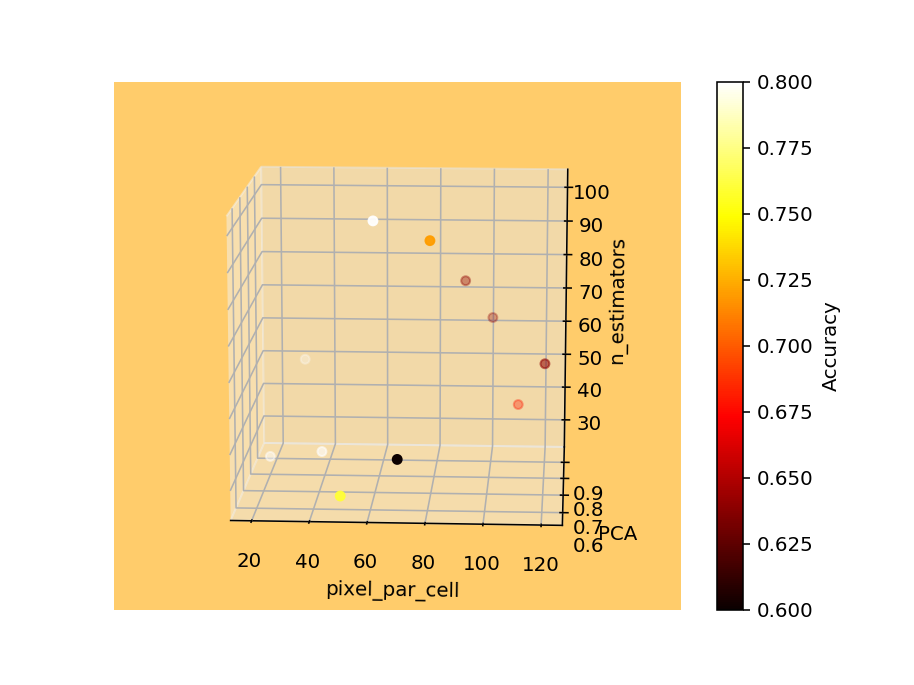

In [15]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plot=ax.scatter(np.arange(20,130,10)
                , [op_p1[i]["num_pca"]for i in range (len(op_p1)) ]
                , [op_p1[i]["num_estimators"]for i in range (len(op_p1)) ],
                c=op_v1, cmap=plt.hot())
ax.set_xlabel('pixel_par_cell')
ax.set_ylabel('PCA')
ax.set_zlabel('n_estimators')
ax.set_facecolor((1.0, 0.8, 0.42))
fig.colorbar(plot,label="Accuracy")
plt.show()

<IPython.core.display.Javascript object>


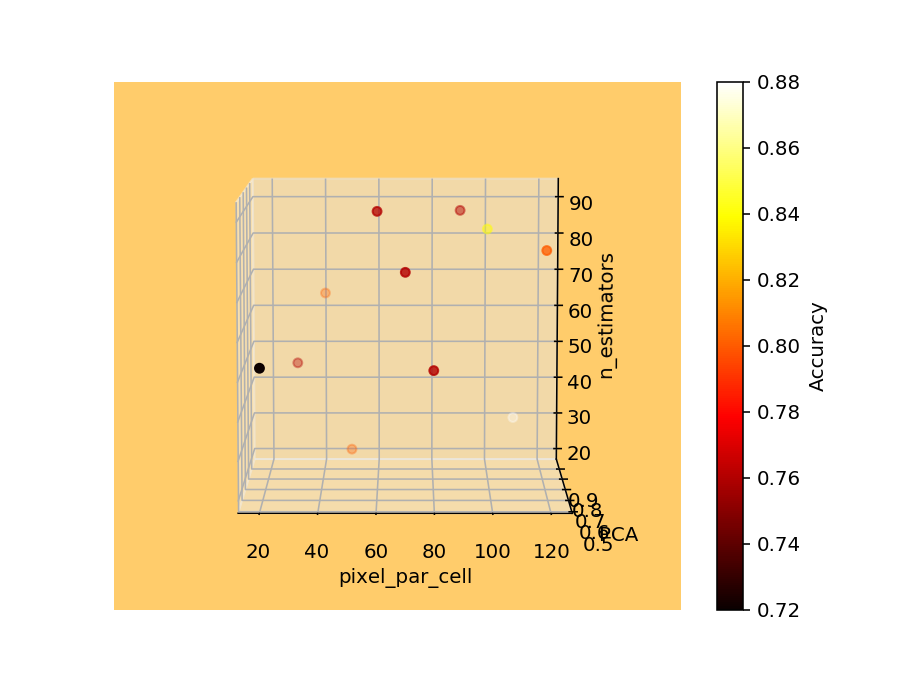

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plot=ax.scatter(np.arange(20,130,10)
                , [op_p2[i]["num_pca"]for i in range (len(op_p2)) ]
                , [op_p2[i]["num_estimators"]for i in range (len(op_p2)) ],
                c=op_v2, cmap=plt.hot())
ax.set_xlabel('pixel_par_cell')
ax.set_ylabel('PCA')
ax.set_zlabel('n_estimators')
ax.set_facecolor((1.0, 0.8, 0.42))
fig.colorbar(plot,label="Accuracy")
plt.show()

<IPython.core.display.Javascript object>


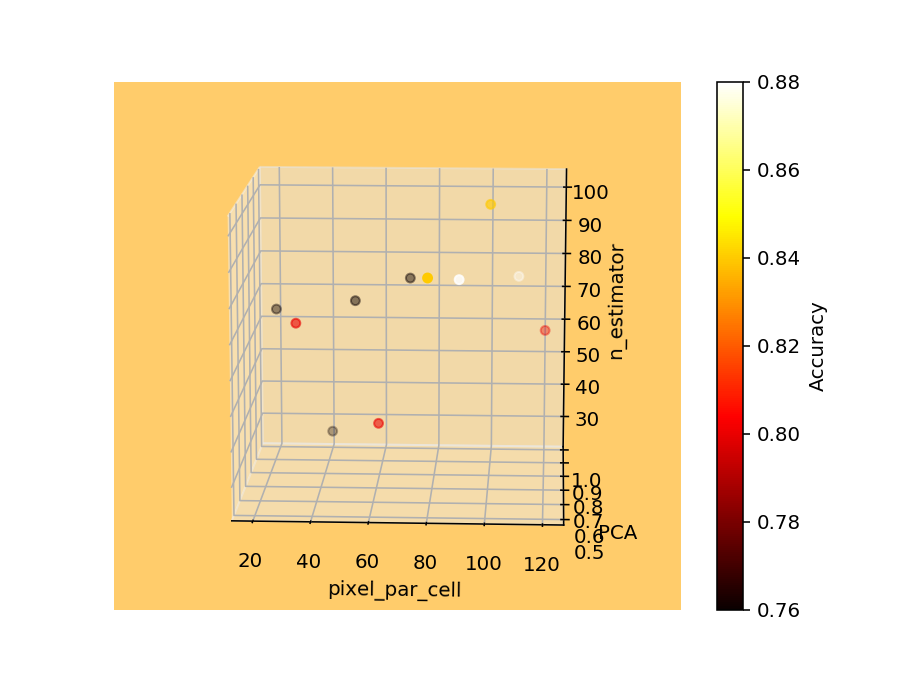

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plot=ax.scatter(np.arange(20,130,10)
                , [op_p3[i]["num_pca"]for i in range (len(op_p3)) ]
                , [op_p3[i]["num_estimators"]for i in range (len(op_p3)) ],
                c=op_v3, cmap=plt.hot())
ax.set_xlabel('pixel_par_cell')
ax.set_ylabel('PCA')
ax.set_zlabel('n_estimator')
ax.set_facecolor((1.0, 0.8, 0.42))
fig.colorbar(plot,label="Accuracy")
plt.show()

<IPython.core.display.Javascript object>


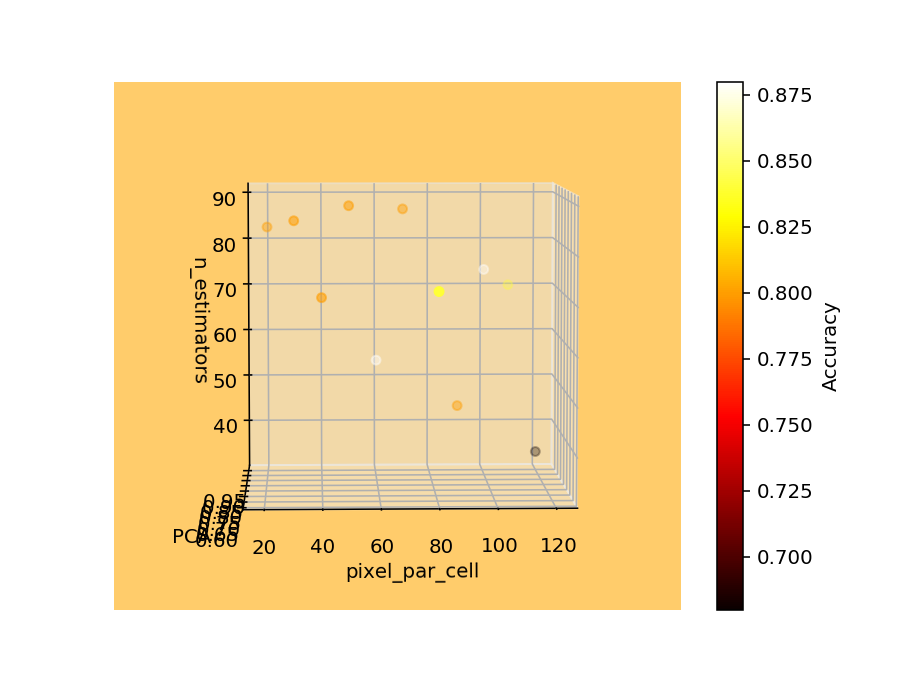

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plot=ax.scatter(np.arange(20,130,10)
                , [op_p4[i]["num_pca"]for i in range (len(op_p4)) ]
                , [op_p4[i]["num_estimators"]for i in range (len(op_p4)) ],
                c=op_v4, cmap=plt.hot())
ax.set_xlabel('pixel_par_cell')
ax.set_ylabel('PCA')
ax.set_zlabel('n_estimators')
ax.set_facecolor((1.0, 0.8, 0.42))
fig.colorbar(plot,label="Accuracy")
plt.show()